# Figure.8:Instrumental line

In [1]:
################## import packages #############################
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
# If you do not understand the lines above, ignore it.

import numpy as np
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import bilby
import csv
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
from gwosc.locate import get_event_urls
from gwpy.signal import filter_design
import os
from bilby.core.prior import PriorDict


import sys
# sys.path.append("..")
# from modular_code_part.combmodel import combmodel as combmodel
# from modular_code_part.burstevidence_version4 import burstevidence2_response_notchout as burstevidence
sys.path.append(".")
from modular_code_part.burstevidence_newcomb import burstevidence2_old_response as burstevidence_old
from modular_code_part.burstevidence_newcomb import burstevidence2_qnm_response as burstevidence
from modular_code_part.comb_models_version3 import qnmcombmodel_cut as combmodel
from modular_code_part.notch import NotchFilterProcessor as NotchFilterProcessor
from modular_code_part.detresponse import RIeff as RIeff

################################################# define functions #########################################################
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back,
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    #norm = 1./np.sqrt(1./(dt*2))
    norm = 1
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

def dimention2to1(i,j):
    temp = max(i-1,j-1)
    return temp**2+i+(temp-j)+1

def dimention1to2(ij_input):
    ij = ij_input-1
    temp = int(np.sqrt(ij))
    #part = temp*2+1
    #n = ij - temp**2 +1
    minus = ij - temp**2 - temp  ##j-i = n - temp-1
    if minus==0:
        j = temp
        i = temp
    elif minus>0:
        i = temp
        j = temp-minus
    else:
        j =temp
        i = temp+minus
    return (i+1,j+1)
################################################# define functions end #####################################################

################################################# parameter setting #########################################################
## lh range for each parallel run on workstation 52C (nlh=0-51)
nlh = 10
deltalh = 6
lhi = deltalh*nlh
lhf = deltalh*nlh+deltalh
##See lhlistnew

## 0: old likelihood; 1: new likelihood
likelihood_index = 1

whether_print_header = 1
## 0: create a new csv with header; 1: write in the existing csv
# whether_print_header = 1
likelihoodlist = ['oldlikelihood','newlikelihood']
likelihood_string = likelihoodlist[likelihood_index]

eventname = 'GW150914'
# fH =  188.7 # the special frequency that resonances vanish in unit of Hz
# fRD = 250.2 # the ringdown frequency in unit of Hz
# Dfmin = 3.0 # the minimum frequency spacing
# Dfmax = 7.6 # the maximum frequency spacing
# Dfmaxp = 6.8
echoamplitude = 0
tlag = 7.4*1e-3
durationlist = np.array([114,48.6, 24.3, 12.1, 4.9]) # benchmarks of time duration in unit of second
signallist = ['time48.npy','time24.npy','time12.npy','time5.npy']
chi = 0.67
f_RD = (1.5251-1.1568*(1-chi)**0.129)/(2*np.pi)
R_bar = 0.00547/(1+1/np.sqrt(1-chi**2))
G = 6.67430e-11
c = 299792458
M_sun = 1.988409870698051e30
finalmass_150914 = 61.5
## 61.5 M_sun is the final mass of the binary system, which is the source-frame mass
## M f_RD is dimensionless, to convert to Hz, we need to use:
## G M f_RD /c^3 = 1.5251-1.1568*(1-chi)**0.129


f_RD = f_RD * c**3 / G / M_sun /finalmass_150914
R_bar = R_bar * c**3 / G / M_sun / finalmass_150914
## f_RD,R_bar =  274.50202917591366, 7.693779311787322



gps = 1126259462.4 # roughly the main event time
fnameH = 'H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5'
fnameL = 'L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5'

## background estimation parameters (use noise prior to the main event in [gps-t0-n*duration,gps-t0])
t0 = 100 # in unit of second
n=5 # the number of duration for noise search

# ## comb parameters (teeth width, amplitude upper bound specified latter as a function of duration)
# spacingi1 = Dfmin # in unit of Hz
# spacingi2 = Dfmax # in unit of Hz
# fmini1 = np.max(np.array([50,fH-30*Dfmaxp])) # in unit of Hz
# fmini2 = fH-(fH-fmini1)/4 # in unit of Hz
# fmaxi1 = fH # in unit of Hz
# fmaxi2 = 1.1*fRD # in unit of Hz
# ampti1 = 1e-25
resampti = 1
resdti = tlag
resph01 = -0.5*np.pi
resph02 = 1.5*np.pi
f_minimal = 50

## psd setting
samplingrate = 4096 # up to now, we do not use this parameter yet
dt = 1/samplingrate # time resolution in unit of second
NFFT = int(0.5 / dt) # the segment length is 0.5s
fs = int(1/ dt)
psd_window = np.blackman(NFFT)
NOVL = int(NFFT/2)
psd_params = {
    'Fs': fs,
    'NFFT': NFFT,
    'window': psd_window,
    'noverlap': NOVL
    }

##notch out setting
notchout_list_l_large = np.array([60,2*60,3*60,4*60]) #The frequency center for notching out
notchout_list_errorbar_l_large = np.array([0.06,2*0.06,3*0.06,4*0.06])#The frequency error bar for notching out
notchout_list_h_large = np.array([60,2*60,3*60,4*60] )#The frequency center for notching out
notchout_list_errorbar_h_large =np.array([0.06,2*0.06,3*0.06,4*0.06]) #The frequency error bar for notching out
notchout_list_l_small = np.array([73.9,122.2,147.8,170.5,196.1,244.4,267.1]) #The frequency center for notching out
notchout_list_errorbar_l_small = np.array([0.03,0.03,0.03,0.03,0.03,0.03,0.03])#The frequency error bar for notching out
notchout_list_h_small = np.array([64,128,160,192,256,272])#The frequency center for notching out
notchout_list_errorbar_h_small =np.array([0.03,0.03,0.03,0.03,0.03,0.03]) #The frequency error bar for notching out

notchout_list_l = np.concatenate((notchout_list_l_large, notchout_list_l_small), axis = 0)
notchout_list_h = np.concatenate((notchout_list_h_large, notchout_list_h_small), axis = 0)
notchout_list_errorbar_l = np.concatenate((notchout_list_errorbar_l_large, notchout_list_errorbar_l_small), axis = 0)
notchout_list_errorbar_h = np.concatenate((notchout_list_errorbar_h_large, notchout_list_errorbar_h_small), axis = 0)

notchout_errorbar_for_likelihood = [-0.3,0.3]
notchout_errorbar_for_psd = [-2,2]

notchout_amplitude_list = [6,5,5,5] #The normalized strain data in frequency domain higher than this parameter will be outched out.
croptime = 1 # in unit of second

## sampler setting
npoints = 2000
# nact = 10
maxmcmc = 10000
walks = 100

# LVK arm unit vectors
uL=np.array([-0.95457412153, -0.14158077340, -0.26218911324])
vL=np.array([0.29774156894, -0.48791033647, -0.82054461286])
uH=np.array([-0.22389266154, 0.79983062746, 0.55690487831])
vH=np.array([-0.91397818574, 0.02609403989, -0.40492342125])
uV=np.array([-0.70045821479,0.20848948619,0.68256166277])
vV=np.array([-0.05379255368,-0.96908180549,0.24080451708])

xH=np.array([-2.16141492636*1e6, -3.83469517889*1e6, 4.6003502264*1e6])
xL=np.array([-7.42760447238*1e4, -5.49628371971*1e6, 3.22425701744*1e6])
xV=np.array([4.54637409900*1e6,8.42989697626*1e5,4.37857696241*1e6])

rai, dei ,GMSTi = 1.6768742520431272, -1.2148064804269771, 9.383265080483397
psii = 0
phi0i = 0
Aplusi = 1
Acrossi = 0
# ## dry run setting
# npoints = 10
# nact = 1
# maxmcmc = 100
# walks = 1

for nduration in [0]:

    # nduration = 1
    duration = int(durationlist[nduration]/dt)*dt # time duration in unit of second
    notchout_amplitude = notchout_amplitude_list[nduration]
    Nt = int(duration/dt) # strain data timeseries length
    df=1/duration

    # frequency_shift = np.arange(0,int(1/dt),df) - samplingrate/2
    # echoraw0 = np.load('../signal/'+signallist[nduration])
    # echoraw = echoamplitude*echoraw0
    # fre_echo_raw = np.fft.fft(echoraw)
    # fre_echo_raw_shift = np.fft.fftshift(fre_echo_raw)

    # RHeff = RIeff(rai, dei, psii, Aplusi, Acrossi, phi0i, GMSTi, uH, vH, xH, frequency_shift)
    # RLeff = RIeff(rai, dei, psii, Aplusi, Acrossi, phi0i, GMSTi, uL, vL, xL, frequency_shift)

    # echorawfre_H = np.fft.fftshift(RHeff * fre_echo_raw_shift + np.conjugate(RHeff * fre_echo_raw_shift)[::-1])/2
    # echorawfre_L = np.fft.fftshift(RLeff * fre_echo_raw_shift + np.conjugate(RLeff * fre_echo_raw_shift)[::-1])/2

    # echoraw_H=np.fft.ifft(echorawfre_H)
    # echoraw_H = np.fft.irfft(echorawfre_H[0:Nt//2+1])
    # echoraw_L = np.fft.irfft(echorawfre_L[0:Nt//2+1])
    # if len(echoraw_H) != Nt:
    #     echoraw_H = np.append(echoraw_H,0)
    #     echoraw_L = np.append(echoraw_L,0)

    frequency = np.arange(0,int(1/dt/2),df)

    ## directory
    label0 = eventname+'_ndata={0:1d}'.format(n)+'_npoint={0:1d}'.format(npoints)+'_duration={:.0f}'.format(duration)+'_'+likelihood_string
    outdirtemp = 'outdir_nonotch_GW150914noise_version3.5_psd0.5_rwalk'
    outdir = '../'+outdirtemp+'/'+label0
    # if(whether_print_header == 0):
    #     headers = ['duration',  'indexlh', 'indexl', 'indexh', 'logB', 'maxloglikelihood', 'SNR_inj_median', 'SNR_inj_global','SNR_comb_median', 'SNR_comb_global', 'run_time',
    #         # 'total_croptimel', 'total_croptimeh','notchlist_l', 'notchlist_h',
    #         'width_median', 'width_plus', 'width_minus', 'width_global',
    #         'amplitude_median', 'amplitude_plus', 'amplitude_minus', 'amplitude_global',
    #         'phase_median', 'phase_plus', 'phase_minus', 'phase_global',
    #         'spacing_median', 'spacing_plus', 'spacing_minus', 'spacing_global',
    #         'fmin_median', 'fmin_plus', 'fmin_minus', 'fmin_global',
    #         'fmax_median', 'fmax_plus', 'fmax_minus', 'fmax_global',
    #         'res_phase0_median', 'res_phase0_plus', 'res_phase0_minus', 'res_phase0_global',
    #         'res_amplitude_median', 'res_dt_median','duration_median']
    #     if not os.path.exists('../'+outdirtemp+'/'):
    #         os.mkdir('../'+outdirtemp+'/')
    #     if not os.path.exists(outdir):
    #         os.mkdir(outdir)
    #     with open(outdir+'/../'+label0+'_all.csv', 'w') as f:
    #         f_csv = csv.writer(f)
    #         f_csv.writerow(headers)
    #     whether_print_header = 1
    ################################################ parameter setting end #######################################################


    # widthi = 11/duration # teeth width in unit of Hz
    # ampti2 = 5*1e-23/np.sqrt(4*df) # from normalization 5*ASD*sqrt(4*df)
    ################################################ strain data setting ####################################################
    strainLall = TimeSeries.read('noise/'+fnameL,format='hdf5.gwosc',start=gps-t0-n*duration-duration, end=gps-t0+duration)
    strainHall = TimeSeries.read('noise/'+fnameH,format='hdf5.gwosc',start=gps-t0-n*duration-duration, end=gps-t0+duration)
    ##前后各增加一段以保证whiten时数据足够
    Lpart=np.split(strainLall,n+2)
    Hpart=np.split(strainHall,n+2)
    Lpart.reverse()
    Hpart.reverse()
    duration
    lhlist = np.arange(1,544)#the number 544 can result in the length of lhlistnew equal to 52*10
    lhlist2d = [dimention1to2(lh) for lh in lhlist]
    lhlistnew = np.array([l!=h for l,h in lhlist2d])*lhlist
    lhlistnew = lhlistnew[lhlistnew!=0]

    # for lh in lhlistnew[lhi:lhf]:
    for lh in [3]:
        label = label0+'lh'+str(lh)
        indexl,indexh = dimention1to2(lh)

        noiseL = Lpart[indexl]
        noiseH = Hpart[indexh]

        noiseLp = (np.concatenate((Lpart[indexl+1],Lpart[indexl],Lpart[indexl-1])))
        noiseHp = (np.concatenate((Hpart[indexh+1],Hpart[indexh],Hpart[indexh-1])))

        # strainL = noiseL + echoraw_L
        # strainH = noiseH + echoraw_H
        # strainLp = noiseLp + np.concatenate((np.zeros(Nt),echoraw_L,np.zeros(Nt)),axis=0)
        # strainHp = noiseHp + np.concatenate((np.zeros(Nt),echoraw_H,np.zeros(Nt)),axis=0)
        ################################################ generate origin data ##################################################
        Pxx_strainL_origin, freqs = mlab.psd(noiseL, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)
        psd_strainL_origin = interp1d(freqs, Pxx_strainL_origin)
        Pxx_strainH_origin, freqs = mlab.psd(noiseH, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)
        psd_strainH_origin = interp1d(freqs, Pxx_strainH_origin)

        noiseLpW_origin = whiten(noiseLp, psd_strainL_origin, dt)
        noiseHpW_origin = whiten(noiseHp, psd_strainH_origin, dt)
        noisefreL_origin = dt * np.fft.fft(noiseLpW_origin[Nt:(2*Nt)])[0:len(frequency)]*np.sqrt(psd_strainL_origin(frequency))
        noisefreH_origin = dt * np.fft.fft(noiseHpW_origin[Nt:(2*Nt)])[0:len(frequency)]*np.sqrt(psd_strainH_origin(frequency))

        strainLpW_origin = whiten(noiseLp, psd_strainL_origin, dt)
        strainHpW_origin = whiten(noiseHp, psd_strainH_origin, dt)
        strainLfre_origin = dt * np.fft.fft(strainLpW_origin[Nt:(2*Nt)])[0:len(frequency)]*np.sqrt(psd_strainL_origin(frequency))
        strainHfre_origin = dt * np.fft.fft(strainHpW_origin[Nt:(2*Nt)])[0:len(frequency)]*np.sqrt(psd_strainH_origin(frequency))
        strainLfre_normalized_abs_origin = np.abs(strainLfre_origin/(np.sqrt(psd_strainL_origin(frequency)/(4*df))))
        strainHfre_normalized_abs_origin = np.abs(strainHfre_origin/(np.sqrt(psd_strainH_origin(frequency)/(4*df))))


## Power main

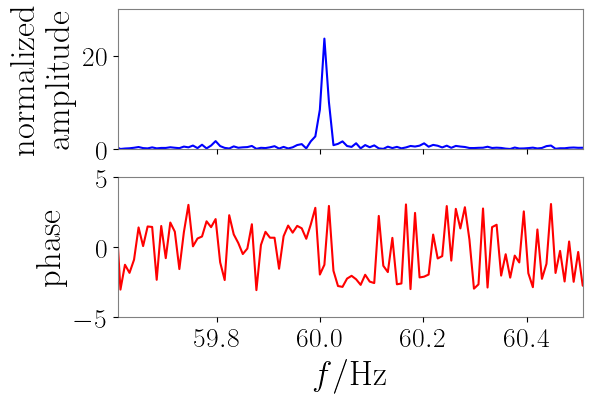

In [2]:
import matplotlib.pyplot as plt
import numpy as np
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

ax1.plot(frequency, strainLfre_normalized_abs_origin, color='b')

ax1.set_xlim(59.61, 60.51)
ax1.set_ylim(0, 30)
ax1.set_ylabel('normalized\namplitude', fontsize=25)

ax1.grid(False)

ax1.tick_params(axis='both', which='major', labelsize=20)

ax1.tick_params(axis='x', labelbottom=False)

ax2.plot(frequency, np.angle(strainLfre_origin)-np.mean(np.angle(strainLfre_origin)), color='r')

ax2.set_ylim(-5, 5)
ax2.set_ylabel('phase', fontsize=25)
ax2.set_xlabel(r'$f/\mathrm{Hz}$', fontsize=25)
ax2.grid(False)

ax2.tick_params(axis='both', which='major', labelsize=20)

plt.subplots_adjust(hspace=0.2)


plt.savefig('GW150914PM.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()

## OMC length dither

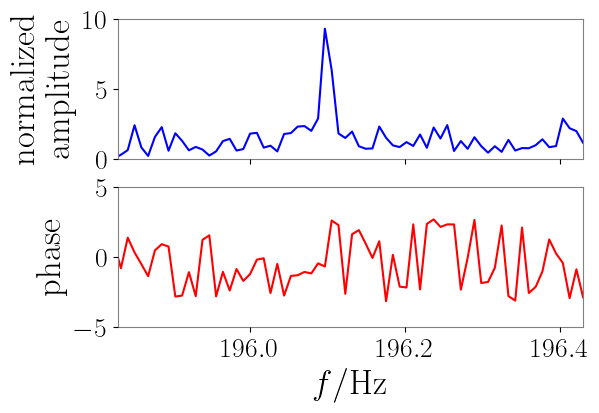

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

ax1.plot(frequency, strainLfre_normalized_abs_origin, color='b')

ax1.set_xlim(195.83, 196.43)
ax1.set_ylim(0, 10)
ax1.set_ylabel('normalized\namplitude', fontsize=25)

ax1.grid(False)

ax1.tick_params(axis='both', which='major', labelsize=20)

ax1.tick_params(axis='x', labelbottom=False)

ax2.plot(frequency, np.angle(strainLfre_origin)-np.mean(np.angle(strainLfre_origin)), color='r')

ax2.set_ylim(-5, 5)
ax2.set_ylabel('phase', fontsize=25)
ax2.set_xlabel(r'$f/\mathrm{Hz}$', fontsize=25)
ax2.grid(False)

ax2.tick_params(axis='both', which='major', labelsize=20)

plt.subplots_adjust(hspace=0.2)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.savefig('GW150914OMC.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()

## Test-mass violin mode

In [ ]:
################## import packages #############################
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
# If you do not understand the lines above, ignore it.

import numpy as np
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import bilby
import csv
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
from gwosc.locate import get_event_urls
from gwpy.signal import filter_design
import os
from bilby.core.prior import PriorDict


import sys
# sys.path.append("..")
# from modular_code_part.combmodel import combmodel as combmodel
# from modular_code_part.burstevidence_version4 import burstevidence2_response_notchout as burstevidence
sys.path.append(".")
from modular_code_part.burstevidence_newcomb import burstevidence2_old_response as burstevidence_old
from modular_code_part.burstevidence_newcomb import burstevidence2_qnm_response as burstevidence
from modular_code_part.comb_models_version3 import qnmcombmodel_cut as combmodel
from modular_code_part.notch import NotchFilterProcessor as NotchFilterProcessor
from modular_code_part.detresponse import RIeff as RIeff

################################################# define functions #########################################################
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    #freqs1 = np.linspace(0,2048,int(Nt/2)+1)这东西分明没用到啊...为啥要定义这东西

    # whitening: transform to freq domain, divide by asd, then transform back,
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    #norm = 1./np.sqrt(1./(dt*2))
    norm = 1
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

def dimention2to1(i,j):
    temp = max(i-1,j-1)
    return temp**2+i+(temp-j)+1
    ## 从i，j转换到ij，注意第一项编号是1

def dimention1to2(ij_input):
    ij = ij_input-1
    temp = int(np.sqrt(ij)) ##表示该组中最大的数字
    #part = temp*2+1 ##表示该组共有多少个元素
    #n = ij - temp**2 +1 ##表示处于该组第几个位置
    minus = ij - temp**2 - temp  ##j-i = n - temp-1
    if minus==0:
        j = temp
        i = temp
    elif minus>0:
        i = temp
        j = temp-minus
    else:
        j =temp
        i = temp+minus
    return (i+1,j+1)
################################################# define functions end #####################################################

################################################# parameter setting #########################################################
## lh range for each parallel run on workstation 52C (nlh=0-51)
nlh = 10
deltalh = 6
lhi = deltalh*nlh
lhf = deltalh*nlh+deltalh
##See lhlistnew

## 0: old likelihood; 1: new likelihood
likelihood_index = 1

whether_print_header = 1
## 0: create a new csv with header; 1: write in the existing csv
# whether_print_header = 1
likelihoodlist = ['oldlikelihood','newlikelihood']
likelihood_string = likelihoodlist[likelihood_index]

eventname = 'GW150914'
# fH =  188.7 # the special frequency that resonances vanish in unit of Hz
# fRD = 250.2 # the ringdown frequency in unit of Hz
# Dfmin = 3.0 # the minimum frequency spacing
# Dfmax = 7.6 # the maximum frequency spacing
# Dfmaxp = 6.8
echoamplitude = 0
tlag = 7.4*1e-3
durationlist = np.array([200,48.6, 24.3, 12.1, 4.9]) # benchmarks of time duration in unit of second
signallist = ['time48.npy','time24.npy','time12.npy','time5.npy']
chi = 0.67
f_RD = (1.5251-1.1568*(1-chi)**0.129)/(2*np.pi)
R_bar = 0.00547/(1+1/np.sqrt(1-chi**2))
G = 6.67430e-11
c = 299792458
M_sun = 1.988409870698051e30
finalmass_150914 = 61.5
## Source-frame or detector-frame?
## 61.5 M_sun is the final mass of the binary system, which is the source-frame mass
## M f_RD is dimensionless, to convert to Hz, we need to use:
## G M f_RD /c^3 = 1.5251-1.1568*(1-chi)**0.129


f_RD = f_RD * c**3 / G / M_sun /finalmass_150914
R_bar = R_bar * c**3 / G / M_sun / finalmass_150914
## f_RD,R_bar =  274.50202917591366, 7.693779311787322



gps = 1126259462.4 # roughly the main event time
fnameH = 'H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5'
fnameL = 'L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5'

## background estimation parameters (use noise prior to the main event in [gps-t0-n*duration,gps-t0])
t0 = 100 # in unit of second
n=5 # the number of duration for noise search

# ## comb parameters (teeth width, amplitude upper bound specified latter as a function of duration)
# spacingi1 = Dfmin # in unit of Hz
# spacingi2 = Dfmax # in unit of Hz
# fmini1 = np.max(np.array([50,fH-30*Dfmaxp])) # in unit of Hz
# fmini2 = fH-(fH-fmini1)/4 # in unit of Hz
# fmaxi1 = fH # in unit of Hz
# fmaxi2 = 1.1*fRD # in unit of Hz
# ampti1 = 1e-25
resampti = 1
resdti = tlag
resph01 = -0.5*np.pi
resph02 = 1.5*np.pi
f_minimal = 50

## psd setting
samplingrate = 4096 # up to now, we do not use this parameter yet
dt = 1/samplingrate # time resolution in unit of second
NFFT = int(0.5 / dt) # the segment length is 0.5s
fs = int(1/ dt)
psd_window = np.blackman(NFFT)
NOVL = int(NFFT/2)
psd_params = {
    'Fs': fs,
    'NFFT': NFFT,
    'window': psd_window,
    'noverlap': NOVL
    }

##notch out setting
notchout_list_l_large = np.array([60,2*60,3*60,4*60]) #The frequency center for notching out
notchout_list_errorbar_l_large = np.array([0.06,2*0.06,3*0.06,4*0.06])#The frequency error bar for notching out
notchout_list_h_large = np.array([60,2*60,3*60,4*60] )#The frequency center for notching out
notchout_list_errorbar_h_large =np.array([0.06,2*0.06,3*0.06,4*0.06]) #The frequency error bar for notching out
notchout_list_l_small = np.array([73.9,122.2,147.8,170.5,196.1,244.4,267.1]) #The frequency center for notching out
notchout_list_errorbar_l_small = np.array([0.03,0.03,0.03,0.03,0.03,0.03,0.03])#The frequency error bar for notching out
notchout_list_h_small = np.array([64,128,160,192,256,272])#The frequency center for notching out
notchout_list_errorbar_h_small =np.array([0.03,0.03,0.03,0.03,0.03,0.03]) #The frequency error bar for notching out

notchout_list_l = np.concatenate((notchout_list_l_large, notchout_list_l_small), axis = 0)
notchout_list_h = np.concatenate((notchout_list_h_large, notchout_list_h_small), axis = 0)
notchout_list_errorbar_l = np.concatenate((notchout_list_errorbar_l_large, notchout_list_errorbar_l_small), axis = 0)
notchout_list_errorbar_h = np.concatenate((notchout_list_errorbar_h_large, notchout_list_errorbar_h_small), axis = 0)

notchout_errorbar_for_likelihood = [-0.3,0.3]
notchout_errorbar_for_psd = [-2,2]

notchout_amplitude_list = [6,5,5,5] #The normalized strain data in frequency domain higher than this parameter will be outched out.
croptime = 1 # in unit of second

## sampler setting
npoints = 2000
# nact = 10
maxmcmc = 10000
walks = 100

# LVK arm unit vectors
uL=np.array([-0.95457412153, -0.14158077340, -0.26218911324])
vL=np.array([0.29774156894, -0.48791033647, -0.82054461286])
uH=np.array([-0.22389266154, 0.79983062746, 0.55690487831])
vH=np.array([-0.91397818574, 0.02609403989, -0.40492342125])
uV=np.array([-0.70045821479,0.20848948619,0.68256166277])
vV=np.array([-0.05379255368,-0.96908180549,0.24080451708])

xH=np.array([-2.16141492636*1e6, -3.83469517889*1e6, 4.6003502264*1e6])
xL=np.array([-7.42760447238*1e4, -5.49628371971*1e6, 3.22425701744*1e6])
xV=np.array([4.54637409900*1e6,8.42989697626*1e5,4.37857696241*1e6])

rai, dei ,GMSTi = 1.6768742520431272, -1.2148064804269771, 9.383265080483397
psii = 0
phi0i = 0
Aplusi = 1
Acrossi = 0
# ## dry run setting
# npoints = 10
# nact = 1
# maxmcmc = 100
# walks = 1

for nduration in [0]:

    # nduration = 1
    duration = int(durationlist[nduration]/dt)*dt # time duration in unit of second
    notchout_amplitude = notchout_amplitude_list[nduration]
    Nt = int(duration/dt) # strain data timeseries length
    df=1/duration

    # frequency_shift = np.arange(0,int(1/dt),df) - samplingrate/2
    # echoraw0 = np.load('../signal/'+signallist[nduration])
    # echoraw = echoamplitude*echoraw0
    # fre_echo_raw = np.fft.fft(echoraw)
    # fre_echo_raw_shift = np.fft.fftshift(fre_echo_raw)

    # RHeff = RIeff(rai, dei, psii, Aplusi, Acrossi, phi0i, GMSTi, uH, vH, xH, frequency_shift)
    # RLeff = RIeff(rai, dei, psii, Aplusi, Acrossi, phi0i, GMSTi, uL, vL, xL, frequency_shift)

    # echorawfre_H = np.fft.fftshift(RHeff * fre_echo_raw_shift + np.conjugate(RHeff * fre_echo_raw_shift)[::-1])/2
    # echorawfre_L = np.fft.fftshift(RLeff * fre_echo_raw_shift + np.conjugate(RLeff * fre_echo_raw_shift)[::-1])/2

    # echoraw_H=np.fft.ifft(echorawfre_H)
    # echoraw_H = np.fft.irfft(echorawfre_H[0:Nt//2+1])
    # echoraw_L = np.fft.irfft(echorawfre_L[0:Nt//2+1])
    # if len(echoraw_H) != Nt:
    #     echoraw_H = np.append(echoraw_H,0)
    #     echoraw_L = np.append(echoraw_L,0)

    frequency = np.arange(0,int(1/dt/2),df)

    ## directory
    label0 = eventname+'_ndata={0:1d}'.format(n)+'_npoint={0:1d}'.format(npoints)+'_duration={:.0f}'.format(duration)+'_'+likelihood_string
    outdirtemp = 'outdir_nonotch_GW150914noise_version3.5_psd0.5_rwalk'
    outdir = '../'+outdirtemp+'/'+label0
    # if(whether_print_header == 0):
    #     headers = ['duration',  'indexlh', 'indexl', 'indexh', 'logB', 'maxloglikelihood', 'SNR_inj_median', 'SNR_inj_global','SNR_comb_median', 'SNR_comb_global', 'run_time',
    #         # 'total_croptimel', 'total_croptimeh','notchlist_l', 'notchlist_h',
    #         'width_median', 'width_plus', 'width_minus', 'width_global',
    #         'amplitude_median', 'amplitude_plus', 'amplitude_minus', 'amplitude_global',
    #         'phase_median', 'phase_plus', 'phase_minus', 'phase_global',
    #         'spacing_median', 'spacing_plus', 'spacing_minus', 'spacing_global',
    #         'fmin_median', 'fmin_plus', 'fmin_minus', 'fmin_global',
    #         'fmax_median', 'fmax_plus', 'fmax_minus', 'fmax_global',
    #         'res_phase0_median', 'res_phase0_plus', 'res_phase0_minus', 'res_phase0_global',
    #         'res_amplitude_median', 'res_dt_median','duration_median']
    #     if not os.path.exists('../'+outdirtemp+'/'):
    #         os.mkdir('../'+outdirtemp+'/')
    #     if not os.path.exists(outdir):
    #         os.mkdir(outdir)
    #     with open(outdir+'/../'+label0+'_all.csv', 'w') as f:
    #         f_csv = csv.writer(f)
    #         f_csv.writerow(headers)
    #     whether_print_header = 1
    ################################################ parameter setting end #######################################################


    # widthi = 11/duration # teeth width in unit of Hz
    # ampti2 = 5*1e-23/np.sqrt(4*df) # from normalization 5*ASD*sqrt(4*df)
    ################################################ strain data setting ####################################################
    strainLall = TimeSeries.read('noise/'+fnameL,format='hdf5.gwosc',start=gps-t0-n*duration-duration, end=gps-t0+duration)
    strainHall = TimeSeries.read('noise/'+fnameH,format='hdf5.gwosc',start=gps-t0-n*duration-duration, end=gps-t0+duration)
    ##前后各增加一段以保证whiten时数据足够
    Lpart=np.split(strainLall,n+2)
    Hpart=np.split(strainHall,n+2)
    Lpart.reverse()
    Hpart.reverse()
    duration
    lhlist = np.arange(1,544)#the number 544 can result in the length of lhlistnew equal to 52*10
    lhlist2d = [dimention1to2(lh) for lh in lhlist]
    lhlistnew = np.array([l!=h for l,h in lhlist2d])*lhlist
    lhlistnew = lhlistnew[lhlistnew!=0]

    # for lh in lhlistnew[lhi:lhf]:
    for lh in [2]:
        label = label0+'lh'+str(lh)
        indexl,indexh = dimention1to2(lh)

        noiseL = Lpart[indexl]
        noiseH = Hpart[indexh]

        noiseLp = (np.concatenate((Lpart[indexl+1],Lpart[indexl],Lpart[indexl-1])))
        noiseHp = (np.concatenate((Hpart[indexh+1],Hpart[indexh],Hpart[indexh-1])))

        # strainL = noiseL + echoraw_L
        # strainH = noiseH + echoraw_H
        # strainLp = noiseLp + np.concatenate((np.zeros(Nt),echoraw_L,np.zeros(Nt)),axis=0)
        # strainHp = noiseHp + np.concatenate((np.zeros(Nt),echoraw_H,np.zeros(Nt)),axis=0)
        ################################################ generate origin data ##################################################
        Pxx_strainL_origin, freqs = mlab.psd(noiseL, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)
        psd_strainL_origin = interp1d(freqs, Pxx_strainL_origin)
        Pxx_strainH_origin, freqs = mlab.psd(noiseH, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)
        psd_strainH_origin = interp1d(freqs, Pxx_strainH_origin)

        noiseLpW_origin = whiten(noiseLp, psd_strainL_origin, dt)
        noiseHpW_origin = whiten(noiseHp, psd_strainH_origin, dt)
        noisefreL_origin = dt * np.fft.fft(noiseLpW_origin[Nt:(2*Nt)])[0:len(frequency)]*np.sqrt(psd_strainL_origin(frequency))
        noisefreH_origin = dt * np.fft.fft(noiseHpW_origin[Nt:(2*Nt)])[0:len(frequency)]*np.sqrt(psd_strainH_origin(frequency))

        strainLpW_origin = whiten(noiseLp, psd_strainL_origin, dt)
        strainHpW_origin = whiten(noiseHp, psd_strainH_origin, dt)
        strainLfre_origin = dt * np.fft.fft(strainLpW_origin[Nt:(2*Nt)])[0:len(frequency)]*np.sqrt(psd_strainL_origin(frequency))
        strainHfre_origin = dt * np.fft.fft(strainHpW_origin[Nt:(2*Nt)])[0:len(frequency)]*np.sqrt(psd_strainH_origin(frequency))
        strainLfre_normalized_abs_origin = np.abs(strainLfre_origin/(np.sqrt(psd_strainL_origin(frequency)/(4*df))))
        strainHfre_normalized_abs_origin = np.abs(strainHfre_origin/(np.sqrt(psd_strainH_origin(frequency)/(4*df))))


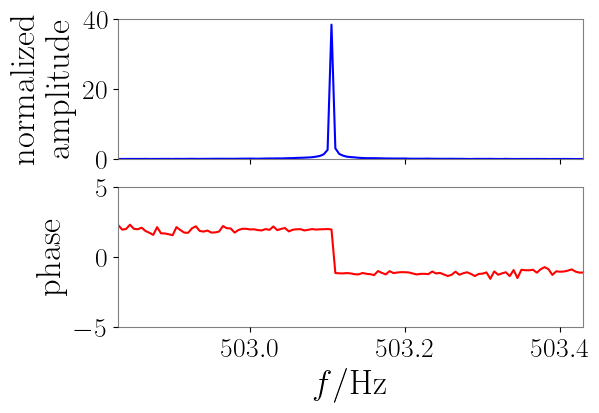

In [5]:
import matplotlib.pyplot as plt
import numpy as np


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

ax1.plot(frequency, strainLfre_normalized_abs_origin, color='b')

ax1.set_xlim(502.83, 503.43)
ax1.set_ylim(0, 40)
ax1.set_ylabel('normalized\namplitude', fontsize=25)

ax1.grid(False)

ax1.tick_params(axis='both', which='major', labelsize=20)

ax1.tick_params(axis='x', labelbottom=False)

ax2.plot(frequency, np.angle(strainLfre_origin)-np.mean(np.angle(strainLfre_origin)), color='r')

ax2.set_ylim(-5, 5)
ax2.set_ylabel('phase', fontsize=25)
ax2.set_xlabel(r'$f/\mathrm{Hz}$', fontsize=25)

ax2.grid(False)

ax2.tick_params(axis='both', which='major', labelsize=20)

plt.subplots_adjust(hspace=0.2)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.savefig('GW150914violinmode1.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()

# Figure.9:non-Gaussian artifacts

## figure(a):Example of a narrow spectral line in GW150914 duration 57s newlikelihood for the highest log B case

In [6]:
################## import packages #############################
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
# If you do not understand the lines above, ignore it.

import numpy as np
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd
import bilby
import csv
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
from gwosc.locate import get_event_urls
from gwpy.signal import filter_design
import os
from bilby.core.prior import PriorDict


import sys

sys.path.append(".")
from modular_code_part.burstevidence_newcomb import burstevidence2_old_response as burstevidence_old
from modular_code_part.burstevidence_newcomb import burstevidence2_qnm_response as burstevidence
from modular_code_part.comb_models_version3 import qnmcombmodel_cut as combmodel
from modular_code_part.notch import NotchFilterProcessor as NotchFilterProcessor
from modular_code_part.detresponse import RIeff as RIeff

################################################# define functions #########################################################
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    hf = np.fft.rfft(strain)
    norm = 1
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

def dimention2to1(i,j):
    temp = max(i-1,j-1)
    return temp**2+i+(temp-j)+1
    ## transform ij to i,j, note that the first item is numbered 1

def dimention1to2(ij_input):
    ij = ij_input-1
    temp = int(np.sqrt(ij))
    ## temp represents the largest number in the group
    ## part = temp*2+1 represents the total number of elements in the group
    ## n = ij - temp**2 +1 represents the position in the group
    minus = ij - temp**2 - temp  ##j-i = n - temp-1
    if minus==0:
        j = temp
        i = temp
    elif minus>0:
        i = temp
        j = temp-minus
    else:
        j =temp
        i = temp+minus
    return (i+1,j+1)
################################################# define functions end #####################################################

################################################# parameter setting #########################################################


lhi = 0
lhf = 2
# nlh = tem
# deltalh = 2
# lhi = deltalh*nlh
# lhf = deltalh*nlh+deltalh
##See lhlistnew

## 0: old likelihood; 1: new likelihood
likelihood_index = 1

whether_print_header = 1
## 0: create a new csv with header; 1: write in the existing csv
# whether_print_header = 0
nduration = 1
notch_index = 1

notchlist = ['nonotch', 'notch']
notch_string = notchlist[notch_index]

likelihoodlist = ['oldlikelihood','newlikelihood']
likelihood_string = likelihoodlist[likelihood_index]

chi = 0.67
f_RD = (1.5251-1.1568*(1-chi)**0.129)/(2*np.pi)
R_bar = 0.00547/(1+1/np.sqrt(1-chi**2))
G = 6.67430e-11
c = 299792458
M_sun = 1.988409870698051e30



eventname = 'GW150914'
if eventname == 'GW150914':
    tlag = 6.9*1e-3
    finalmass_150914 = 61.5 * 1.1
    f_RD = f_RD * c**3 / G / M_sun /finalmass_150914
    R_bar = R_bar * c**3 / G / M_sun / finalmass_150914
    ## f_RD,R_bar = 249.54729925083058, 6.994344828897565
    ## 61.5 M_sun is the final mass of the binary system, which is the source-frame mass
    ## M f_RD is dimensionless, to convert to Hz, we need to use:
    ## G M f_RD /c^3 = 1.5251-1.1568*(1-chi)**0.129
    durationlist = np.array([114.4, 57.2]) # 150914 benchmarks of time duration in unit of second
    # The two durations refer to 1 / (R_bar/2) * 400 and 1 / (R_bar/2) * 200 respectively.
    gps = 1126259462.4 # roughly the main event time
    fnameH = 'H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5'
    fnameL = 'L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5'
    ## background estimation parameters (use noise prior to the main event in [gps-t0-n*duration,gps-t0])
    t0 = 250 # in unit of second
    n = 25 # the number of duration
    if nduration == 0:
        n = 14# the number of duration
        lhlist = np.arange(1,164)#the number 164 can result in the length of lhlistnew equal to 150
        lhlist2d = [dimention1to2(lh) for lh in lhlist]
        lhlistnew = np.array([l!=h for l,h in lhlist2d])*lhlist
        lhlistnew = lhlistnew[lhlistnew!=0]
    if nduration == 1:
        n = 25 # the number of duration
        lhlist = np.arange(1,524) # The number 524 results in the length of lhlistnew equal to 500
        lhlist2d = [dimention1to2(lh) for lh in lhlist]
        lhlistnew = np.array([l!=h for l,h in lhlist2d])*lhlist
        # Here we exclude the cases with l=h because they are correnlated.
        lhlistnew = lhlistnew[lhlistnew!=0]

    notchout_list_l_large = np.array([60,2*60,3*60,4*60]) #The frequency center for notching out
    notchout_list_errorbar_l_large = np.array([0.06,2*0.06,3*0.06,4*0.06])#The frequency error bar for notching out
    notchout_list_h_large = np.array([60,2*60,3*60,4*60] )#The frequency center for notching out
    notchout_list_errorbar_h_large =np.array([0.06,2*0.06,3*0.06,4*0.06]) #The frequency error bar for notching out
    notchout_list_l_small = np.array([73.9,122.2,147.8,170.5,196.1,244.4,267.1]) #The frequency center for notching out
    notchout_list_errorbar_l_small = np.array([0.03,0.03,0.03,0.03,0.03,0.03,0.03])#The frequency error bar for notching out
    notchout_list_h_small = np.array([64,128,160,192,256,272])#The frequency center for notching out
    notchout_list_errorbar_h_small =np.array([0.03,0.03,0.03,0.03,0.03,0.03]) #The frequency error bar for notching out

    notchout_list_l = np.concatenate((notchout_list_l_large, notchout_list_l_small), axis = 0)
    notchout_list_h = np.concatenate((notchout_list_h_large, notchout_list_h_small), axis = 0)
    notchout_list_errorbar_l = np.concatenate((notchout_list_errorbar_l_large, notchout_list_errorbar_l_small), axis = 0)
    notchout_list_errorbar_h = np.concatenate((notchout_list_errorbar_h_large, notchout_list_errorbar_h_small), axis = 0)

    notchout_errorbar_for_likelihood = [-0.3,0.3]
    notchout_errorbar_for_psd = [-2,2]

    notchout_amplitude_list = [6,6] #The normalized strain data in frequency domain higher than this parameter will be outched out.
    croptime = 1 # in unit of second

if eventname == 'GW231226':
    tlag = -4*1e-3
    finalmass_231226 = 71.4 * 1.2
    f_RD = f_RD * c**3 / G / M_sun /finalmass_231226
    R_bar = R_bar * c**3 / G / M_sun / finalmass_231226
    ## f_RD,R_bar = 197.03401954153466, 5.522495654469191
    durationlist = np.array([144.9, 72.4]) # 231226 benchmarks of time duration in unit of second
    gps = 1387620938.3
    fnameH = 'H-H1_GWOSC_O4a_4KHZ_R1-1387618304-4096.hdf5'
    fnameL = 'L-L1_GWOSC_O4a_4KHZ_R1-1387618304-4096.hdf5'
    t0 = 100 # in unit of second
    if nduration == 0:
        n = 15 # the number of duration
        lhlist = np.arange(1,176) # The number 176 results in the length of lhlistnew equal to 150
        lhlist2d = [dimention1to2(lh) for lh in lhlist]
        lhlistnew = np.array([l!=h for l,h in lhlist2d])*np.array([h!=2 for l,h in lhlist2d])*lhlist
        # Here we exclude the cases with l=h because they are correnlated.
        # We also exclude the cases with h=4 because a glitch occurs in the Hanford detector around this time.
        lhlistnew = lhlistnew[lhlistnew!=0]
    if nduration == 1:
        n = 25 # the number of duration

        lhlist = np.arange(1,546) # The number 546 results in the length of lhlistnew equal to 500
        lhlist2d = [dimention1to2(lh) for lh in lhlist]
        lhlistnew = np.array([l!=h for l,h in lhlist2d])*np.array([h!=4 for l,h in lhlist2d])*lhlist
        # Here we exclude the cases with l=h because they are correnlated.
        # We also exclude the cases with h=4 because a glitch occurs in the Hanford detector around this time.
        lhlistnew = lhlistnew[lhlistnew!=0]


    notchout_list_l_large = np.array([60,2*60,3*60,4*60]) #The frequency center for notching out
    notchout_list_errorbar_l_large = np.array([0.06,2*0.06,3*0.06,4*0.06])#The frequency error bar for notching out
    notchout_list_h_large = np.array([60,2*60,3*60,4*60] )#The frequency center for notching out
    notchout_list_errorbar_h_large =np.array([0.06,2*0.06,3*0.06,4*0.06]) #The frequency error bar for notching out
    notchout_list_l_small = np.array([]) #The frequency center for notching out
    notchout_list_errorbar_l_small = np.array([])#The frequency error bar for notching out
    notchout_list_h_small = np.array([])#The frequency center for notching out
    notchout_list_errorbar_h_small =np.array([]) #The frequency error bar for notching out

    notchout_list_l = np.concatenate((notchout_list_l_large, notchout_list_l_small), axis = 0)
    notchout_list_h = np.concatenate((notchout_list_h_large, notchout_list_h_small), axis = 0)
    notchout_list_errorbar_l = np.concatenate((notchout_list_errorbar_l_large, notchout_list_errorbar_l_small), axis = 0)
    notchout_list_errorbar_h = np.concatenate((notchout_list_errorbar_h_large, notchout_list_errorbar_h_small), axis = 0)

    notchout_errorbar_for_likelihood = [-0.3,0.3]
    notchout_errorbar_for_psd = [-2,2]

    notchout_amplitude_list = [6,6] #The normalized strain data in frequency domain higher than this parameter will be outched out.
    croptime = 1 # in unit of second



resampti = 1
resdti = tlag
resph01 = -0.5*np.pi
resph02 = 1.5*np.pi
f_minimal = 50

## psd setting
samplingrate = 4096
dt = 1/samplingrate # time resolution in unit of second
NFFT = int(0.5 / dt) # the segment length is 0.5s
fs = int(1/ dt)
psd_window = np.blackman(NFFT)
NOVL = int(NFFT/2)
psd_params = {
    'Fs': fs,
    'NFFT': NFFT,
    'window': psd_window,
    'noverlap': NOVL
    }

##notch out setting


## sampler setting
npoints = 1000
# nact = 10# up to now, we do not use this parameter yet
maxmcmc = 10000
walks = 100

# LVK arm unit vectors
uL=np.array([-0.95457412153, -0.14158077340, -0.26218911324])
vL=np.array([0.29774156894, -0.48791033647, -0.82054461286])
uH=np.array([-0.22389266154, 0.79983062746, 0.55690487831])
vH=np.array([-0.91397818574, 0.02609403989, -0.40492342125])
uV=np.array([-0.70045821479,0.20848948619,0.68256166277])
vV=np.array([-0.05379255368,-0.96908180549,0.24080451708])

xH=np.array([-2.16141492636*1e6, -3.83469517889*1e6, 4.6003502264*1e6])
xL=np.array([-7.42760447238*1e4, -5.49628371971*1e6, 3.22425701744*1e6])
xV=np.array([4.54637409900*1e6,8.42989697626*1e5,4.37857696241*1e6])

## dry run setting
# npoints = 10
# nact = 1
# maxmcmc = 100
# walks = 1


# nduration = 1
duration = int(durationlist[nduration]/dt)*dt # time duration in unit of second
notchout_amplitude = notchout_amplitude_list[nduration]
Nt = int(duration/dt) # strain data timeseries length
df=1/duration
frequency = np.arange(0,int(1/dt/2),df)

## directory
label0 = eventname+'_ndata={0:1d}'.format(n)+'_npoint={0:1d}'.format(npoints)+'_duration={:.0f}'.format(duration)+'_'+likelihood_string
outdirtemp = 'outdir_'+notch_string+'_'+eventname+'noise_version3.5_psd0.5_rwalk_bsetfit&corner'
outdir = '../'+outdirtemp+'/'+label0

# if(whether_print_header == 0):
#     headers = ['duration',  'indexlh', 'indexl', 'indexh', 'logB', 'maxloglikelihood', 'SNR_comb_median', 'SNR_comb_global', 'run_time',
#         'total_croptimel', 'total_croptimeh','notchlist_l', 'notchlist_h',
#         'width_median', 'width_plus', 'width_minus', 'width_global',
#         'amplitude_median', 'amplitude_plus', 'amplitude_minus', 'amplitude_global',
    #     'phase_median', 'phase_plus', 'phase_minus', 'phase_global',
    #     'spacing_median', 'spacing_plus', 'spacing_minus', 'spacing_global',
    #     'fmin_median', 'fmin_plus', 'fmin_minus', 'fmin_global',
    #     'fmax_median', 'fmax_plus', 'fmax_minus', 'fmax_global',
    #     'res_phase0_median', 'res_phase0_plus', 'res_phase0_minus', 'res_phase0_global',
    #     'res_amplitude_median', 'res_dt_median','duration_median']
    # if notch_index == 0:#nonotch
    #     headers = ['duration',  'indexlh', 'indexl', 'indexh', 'logB', 'maxloglikelihood', 'SNR_comb_median', 'SNR_comb_global', 'run_time',
    #         # 'total_croptimel', 'total_croptimeh','notchlist_l', 'notchlist_h',
    #         'width_median', 'width_plus', 'width_minus', 'width_global',
    #         'amplitude_median', 'amplitude_plus', 'amplitude_minus', 'amplitude_global',
    #         'phase_median', 'phase_plus', 'phase_minus', 'phase_global',
    #         'spacing_median', 'spacing_plus', 'spacing_minus', 'spacing_global',
    #         'fmin_median', 'fmin_plus', 'fmin_minus', 'fmin_global',
    #         'fmax_median', 'fmax_plus', 'fmax_minus', 'fmax_global',
    #         'res_phase0_median', 'res_phase0_plus', 'res_phase0_minus', 'res_phase0_global',
    #         'res_amplitude_median', 'res_dt_median','duration_median']
    # if not os.path.exists('../'+outdirtemp+'/'):
    #     os.mkdir('../'+outdirtemp+'/')
    # if not os.path.exists(outdir):
    #     os.mkdir(outdir)
    # with open(outdir+'/../'+label0+'_all.csv', 'w') as f:
    #     f_csv = csv.writer(f)
    #     f_csv.writerow(headers)
    # whether_print_header = 1
################################################ parameter setting end #######################################################

strainLall = TimeSeries.read('noise/'+fnameL,format='hdf5.gwosc',start=gps-t0-n*duration-duration, end=gps-t0+duration)
strainHall = TimeSeries.read('noise/'+fnameH,format='hdf5.gwosc',start=gps-t0-n*duration-duration, end=gps-t0+duration)
##前后各增加一段以保证whiten时数据足够
Lpart=np.split(strainLall,n+2)
Hpart=np.split(strainHall,n+2)
Lpart.reverse()
Hpart.reverse()



for lh in [212]:

    label = label0+'lh'+str(lh)
    indexl,indexh = dimention1to2(lh)

    noiseL = Lpart[indexl]
    noiseH = Hpart[indexh]

    noiseLp = (np.concatenate((Lpart[indexl+1],Lpart[indexl],Lpart[indexl-1])))
    noiseHp = (np.concatenate((Hpart[indexh+1],Hpart[indexh],Hpart[indexh-1])))

    strainL = noiseL
    strainH = noiseH
    strainLp = noiseLp
    strainHp = noiseHp
    ################################################ generate origin data ##################################################
    Pxx_strainL_origin, freqs = mlab.psd(strainL, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)
    psd_strainL_origin = interp1d(freqs, Pxx_strainL_origin)
    Pxx_strainH_origin, freqs = mlab.psd(strainH, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)
    psd_strainH_origin = interp1d(freqs, Pxx_strainH_origin)

    noiseLpW_origin = whiten(noiseLp, psd_strainL_origin, dt)
    noiseHpW_origin = whiten(noiseHp, psd_strainH_origin, dt)
    noisefreL_origin = dt * np.fft.fft(noiseLpW_origin[Nt:(2*Nt)])[0:len(frequency)]*np.sqrt(psd_strainL_origin(frequency))
    noisefreH_origin = dt * np.fft.fft(noiseHpW_origin[Nt:(2*Nt)])[0:len(frequency)]*np.sqrt(psd_strainH_origin(frequency))

    strainLpW_origin = whiten(strainLp, psd_strainL_origin, dt)
    strainHpW_origin = whiten(strainHp, psd_strainH_origin, dt)
    strainLfre_origin = dt * np.fft.fft(strainLpW_origin[Nt:(2*Nt)])[0:len(frequency)]*np.sqrt(psd_strainL_origin(frequency))
    strainHfre_origin = dt * np.fft.fft(strainHpW_origin[Nt:(2*Nt)])[0:len(frequency)]*np.sqrt(psd_strainH_origin(frequency))
    strainLfre_normalized_abs_origin = np.abs(strainLfre_origin/(np.sqrt(psd_strainL_origin(frequency)/(4*df))))
    strainHfre_normalized_abs_origin = np.abs(strainHfre_origin/(np.sqrt(psd_strainH_origin(frequency)/(4*df))))
    if notch_index == 1:#notch
        processor = NotchFilterProcessor(frequency=frequency, samplingrate=samplingrate, df=df, psd_params=psd_params)

        filteredL, strainLpW, psd_strainL, whether_include_in_likelihood_l,  total_notchlist_l , total_croptime_l= processor.process(
            strainLp, Nt, samplingrate, notchout_amplitude, notchout_list_l, notchout_list_errorbar_l, notchout_errorbar_for_psd, notchout_errorbar_for_likelihood, croptime
        )
        filteredH, strainHpW, psd_strainH, whether_include_in_likelihood_h,  total_notchlist_h , total_croptime_h= processor.process(
            strainHp, Nt, samplingrate, notchout_amplitude, notchout_list_h, notchout_list_errorbar_h, notchout_errorbar_for_psd, notchout_errorbar_for_likelihood, croptime
        )
        # total_croptime = np.max([total_croptime_l, total_croptime_h])

        noiseLpW = whiten(processor.apply_notch_filters(noiseLp, total_notchlist_l, total_croptime_l),psd_strainL, dt)
        noiseHpW = whiten(processor.apply_notch_filters(noiseHp, total_notchlist_h, total_croptime_h),psd_strainH ,dt)
        noiseLfre = dt * np.fft.fft(noiseLpW[(Nt-samplingrate*total_croptime_l):(2*Nt-samplingrate*total_croptime_l)])[0:len(frequency)]*np.sqrt(psd_strainL(frequency))
        noiseHfre = dt * np.fft.fft(noiseHpW[(Nt-samplingrate*total_croptime_h):(2*Nt-samplingrate*total_croptime_h)])[0:len(frequency)]*np.sqrt(psd_strainH(frequency))
        noiseLfre = noiseLfre.value
        noiseHfre = noiseHfre.value

        strainLfre = dt * np.fft.fft(strainLpW[(Nt-samplingrate*total_croptime_l):(2*Nt-samplingrate*total_croptime_l)])[0:len(frequency)]*np.sqrt(psd_strainL(frequency))
        strainHfre = dt * np.fft.fft(strainHpW[(Nt-samplingrate*total_croptime_h):(2*Nt-samplingrate*total_croptime_h)])[0:len(frequency)]*np.sqrt(psd_strainH(frequency))

        strainLfre_normalized_abs = np.abs(strainLfre/(np.sqrt(psd_strainL(frequency)/(4*df))))
        strainHfre_normalized_abs = np.abs(strainHfre/(np.sqrt(psd_strainH(frequency)/(4*df))))
        strainLfre = strainLfre.value
        strainHfre = strainHfre.value

    elif notch_index == 0:#nonotch
        strainLpW = strainLpW_origin
        strainHpW = strainHpW_origin
        psd_strainL = psd_strainL_origin
        psd_strainH = psd_strainH_origin

        noiseLpW = noiseLpW_origin
        noiseHpW = noiseHpW_origin
        noiseLfre = noisefreL_origin.value
        noiseHfre = noisefreH_origin.value

        strainLfre = strainLfre_origin.value
        strainHfre = strainHfre_origin.value

        strainLfre_normalized_abs = strainLfre_normalized_abs_origin
        strainHfre_normalized_abs = strainHfre_normalized_abs_origin
        whether_include_in_likelihood_h = 1
        whether_include_in_likelihood_l = 1
    amplitude_min = (np.mean(np.abs(strainLfre_origin[int(f_minimal/df):int(1.1 * f_RD/df+2)]))+np.mean(np.abs(strainHfre_origin[int(f_minimal/df):int(1.1 * f_RD/df+2)])))/2/100
    # select the frequency range[f_minimal,1.1 * f_RD] for calculating amplitude_min
    amplitude_min = amplitude_min.value
    # amplitude_max = (np.mean(np.abs(strainLfre_origin))+np.mean(np.abs(strainHfre_origin)))/2*10
    amplitude_max = amplitude_min *1000
    def frange(parameters):
        converted_parameters = parameters.copy()
        converted_parameters['z'] = parameters['fmax'] - parameters['fmin'] - parameters['spacing']*10
        return converted_parameters
    priors=PriorDict(conversion_function=frange)
    priors['width']=bilby.core.prior.LogUniform(1/duration, R_bar, 'fw')
    priors['amplitude']=bilby.core.prior.Uniform(amplitude_min, amplitude_max, 'amplitude')

    priors['phase']=bilby.core.prior.Uniform(0, 1, 'phase')
    priors['spacing']=bilby.core.prior.Uniform(R_bar/4, R_bar, 'spacing')
    priors['z'] = bilby.core.prior.Constraint(minimum=0, maximum=f_RD)
    priors['fmin'] = bilby.core.prior.Uniform(f_minimal, 1.1 * f_RD, 'fmin')
    priors['fmax'] = bilby.core.prior.Uniform(f_minimal, 1.1 * f_RD, 'fmax')
    priors['duration'] = duration
    priors['res_amplitude'] = resampti
    priors['res_phase0'] = bilby.core.prior.Uniform(resph01, resph02, 'res_phase0')
    priors['res_dt'] = resdti
    if likelihood_index == 0 :
        likelihood = burstevidence_old(x=frequency, y1=strainHfre, y2=strainLfre,
                                    sn1=psd_strainH(frequency), sn2=psd_strainL(frequency),
                                    function = combmodel, df = df )
    if likelihood_index == 1 :
        likelihood = burstevidence(x=frequency, y1=np.abs(strainHfre), y2=np.abs(strainLfre),
                                angle1=np.angle(strainHfre), angle2=np.angle(strainLfre),
                                sn1=psd_strainH(frequency), sn2=psd_strainL(frequency),
                                function = combmodel, df = df )

    result_file_path = os.path.join('../search_results/outdir_notch_GW150914noise_version3.5_psd0.5_rwalk/GW150914_ndata=25_npoint=1000_duration=57_newlikelihood', f"{label}_result.json")
    result = bilby.result.read_in_result(filename=result_file_path)
    sampling_time = result.sampling_time.total_seconds()

    # result.plot_corner(filename=outdir+'/'+label+'_corner.png')
    logb = result.log_evidence
    maxloglikelihood = result.posterior.max()['log_likelihood']

    posterior_params_m=dict()
    for key in result.search_parameter_keys+result.fixed_parameter_keys:
        posterior_params_m[key]=result.get_one_dimensional_median_and_error_bar(key).median
    posterior_params_p=dict()
    for key in result.search_parameter_keys:
        posterior_params_p[key]=result.get_one_dimensional_median_and_error_bar(key).plus
    posterior_params_n=dict()
    for key in result.search_parameter_keys:
        posterior_params_n[key]=result.get_one_dimensional_median_and_error_bar(key).minus
    posterior_params_g=dict()
    posterior_params_g = result.posterior.loc[[result.posterior.idxmax()['log_likelihood']]].to_dict(orient ='records')[0]


    fmin_m=posterior_params_m['fmin']
    fmax_m=posterior_params_m['fmax']
    res_amplitude_m=posterior_params_m['res_amplitude']
    res_phase0_m=posterior_params_m['res_phase0']
    res_dt_m=posterior_params_m['res_dt']

    fmin_g=posterior_params_g['fmin']
    fmax_g=posterior_params_g['fmax']
    res_amplitude_g=posterior_params_g['res_amplitude']
    res_phase0_g=posterior_params_g['res_phase0']
    res_dt_g=posterior_params_m['res_dt']

    frequencye_m= frequency[int(fmin_m/df):int(fmax_m/df+2)]
    frequencye_g= frequency[int(fmin_g/df):int(fmax_g/df+2)]
    # echo_fre_H = dt*np.fft.fft(echoraw_H)[0:len(frequency)]
    # echo_fre_L = dt*np.fft.fft(echoraw_L)[0:len(frequency)]

    psd_strainLH_list_origin=psd_strainL_origin(frequency)*psd_strainH_origin(frequency)/(psd_strainL_origin(frequency)+res_amplitude_m**2*psd_strainH_origin(frequency))
    psd_strainLH_list=psd_strainL(frequency)*psd_strainH(frequency)/(psd_strainL(frequency)+res_amplitude_m**2*psd_strainH(frequency))
    strainfreN_m_origin = strainHfre_origin/psd_strainH_origin(frequency)+res_amplitude_m*np.exp(res_phase0_m*1j)*np.exp(2*1j*np.pi*res_dt_m*frequency)*strainLfre_origin/psd_strainL_origin(frequency)
    strainfreN_g_origin = strainHfre_origin/psd_strainH_origin(frequency)+res_amplitude_g*np.exp(res_phase0_g*1j)*np.exp(2*1j*np.pi*res_dt_g*frequency)*strainLfre_origin/psd_strainL_origin(frequency)

    strainfreN_m = whether_include_in_likelihood_h*strainHfre/psd_strainH(frequency)+res_amplitude_m*whether_include_in_likelihood_l*np.exp(res_phase0_m*1j)*np.exp(2*1j*np.pi*res_dt_m*frequency)*strainLfre/psd_strainL(frequency)
    strainfreN_g = whether_include_in_likelihood_h*strainHfre/psd_strainH(frequency)+res_amplitude_g*whether_include_in_likelihood_l*np.exp(res_phase0_g*1j)*np.exp(2*1j*np.pi*res_dt_g*frequency)*strainLfre/psd_strainL(frequency)

    hi_m = combmodel(frequencye_m, ** posterior_params_m)[0]* np.exp(1j*combmodel(frequencye_m, ** posterior_params_m)[1])
    rho_optcomb_m = np.sqrt(4*df * np.sum(np.abs(hi_m)**2/psd_strainH_origin(frequencye_m)) +  4*df * np.sum((res_amplitude_m*np.abs(hi_m))**2/psd_strainL_origin(frequencye_m)))
    hi_g = combmodel(frequencye_g, ** posterior_params_g)[0]* np.exp(1j*combmodel(frequencye_g, ** posterior_params_g)[1])
    rho_optcomb_g = np.sqrt(4*df * np.sum(np.abs(hi_g)**2/psd_strainH_origin(frequencye_g)) +  4*df * np.sum((res_amplitude_g*np.abs(hi_g))**2/psd_strainL_origin(frequencye_g)))


0
Iteration 1: [60.0, 180.0, 73.9, 196.1]
1
0
Iteration 1: [60.0, 120.0, 180.0, 128.0, 256.0]
1


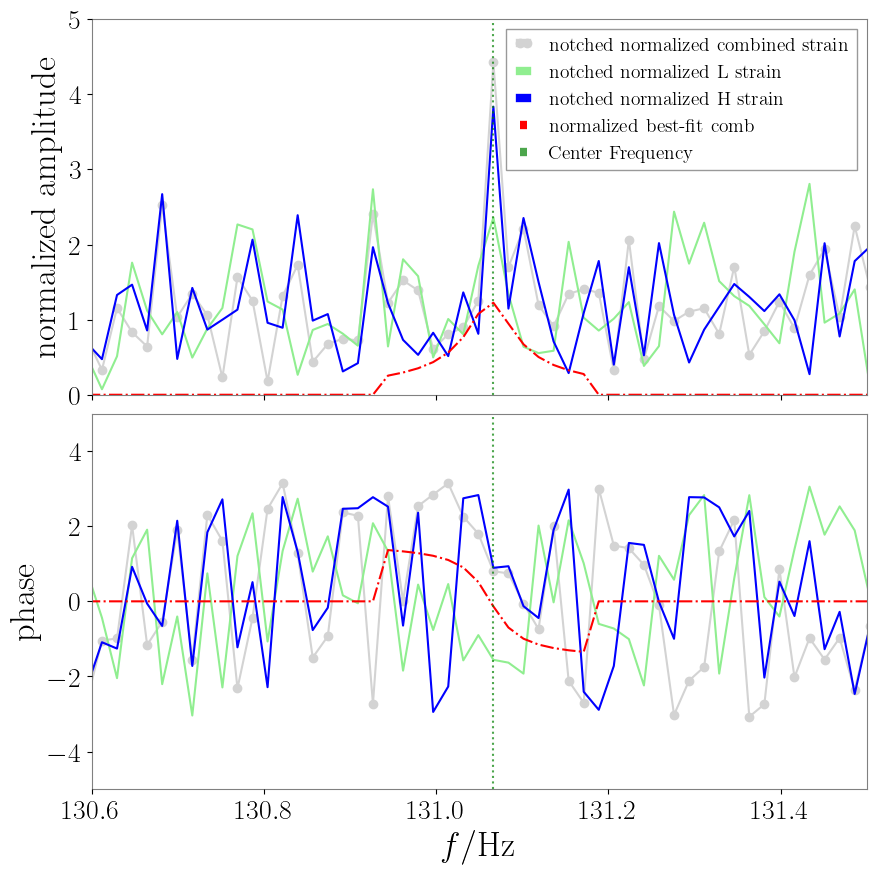

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'hspace': 0.05})

ax1.plot(frequency, np.abs(strainfreN_g*np.sqrt(psd_strainLH_list*(4*df))),
         label='notched normalized combined strain', color='lightgray', marker='o')
ax1.plot(frequency, np.abs(strainLfre_normalized_abs),
          color='lightgreen', label='notched normalized L strain')
ax1.plot(frequency, np.abs(strainHfre_normalized_abs),
          color='b',label='notched normalized H strain')
ax1.plot(frequencye_g, np.abs(hi_g*np.sqrt((4*df)/psd_strainH(frequencye_g)+res_amplitude_g**2*(4*df)/psd_strainL(frequencye_g))),
         label='normalized best-fit comb', color='r', linestyle='-.')

f_center = 131.0665
ax1.axvline(x=f_center, color='green', linestyle=':', linewidth=1.5, alpha=0.7, label='Center Frequency')

ax1.set_xlim(130.6, 131.5)
ax1.set_ylim(0, 5)
ax1.set_ylabel('normalized amplitude', fontsize=25)
ax1.legend(loc='upper right',fontsize = 14)
ax1.grid(False)

ax1.tick_params(axis='x', labelbottom=False, labelsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)

ax2.plot(frequency, np.angle(strainfreN_g),
          color='lightgray', marker='o')
ax2.plot(frequency, np.angle(strainLfre),
          color='lightgreen')
ax2.plot(frequency, np.angle(strainHfre),
          color='b')
ax2.plot(frequencye_g, np.angle(hi_g),
         color='r', linestyle='-.')

ax2.axvline(x=f_center, color='green', linestyle=':', linewidth=1.5, alpha=0.7)

ax2.set_ylim(-5, 5)
ax2.set_ylabel('phase', fontsize=25)
ax2.set_xlabel(r'$f/\mathrm{Hz}$', fontsize=25)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.grid(False)

plt.subplots_adjust(hspace=0.2)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.savefig('GW150914duration57new.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()

## figure(b):Corner plot of the overall posterior for GW150914 duration 114s old likelihood

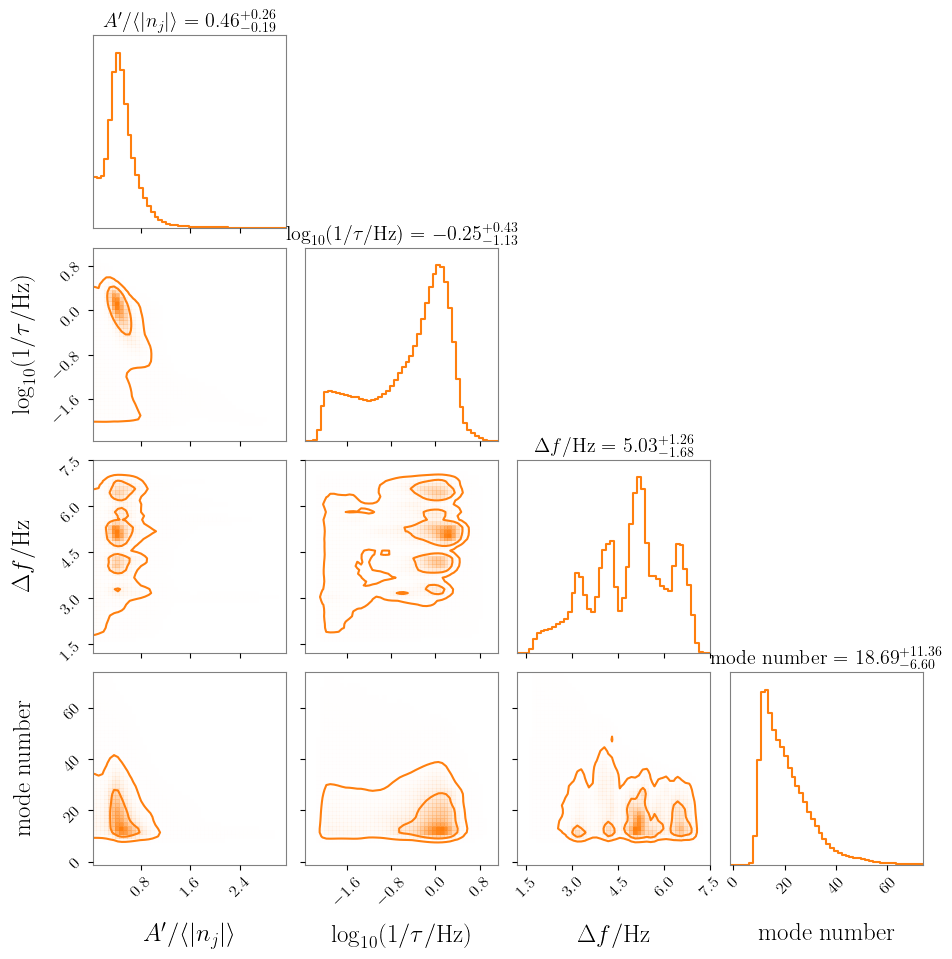

In [8]:
import json
import corner
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

result_path = "GW150914duration114_oldlikelihood.json"

with open(result_path, 'r') as f:
    result_data = json.load(f)

if 'posterior' in result_data:
    posterior_data = result_data['posterior']
elif 'samples' in result_data:
    posterior_data = result_data['samples']
else:
    sample_keys = [k for k in result_data.keys() if isinstance(result_data[k], (list, dict))]
    posterior_data = result_data[sample_keys[0]]

posterior = pd.DataFrame(posterior_data)

noise_mean_linear = (6.3e-25) / np.sqrt(2)
A_min_linear = noise_mean_linear * 100

amp_vals = posterior['amplitude'].values / A_min_linear
width_vals = posterior['width'].values
spacing_vals = posterior['spacing'].values
df_over_spacing = (posterior['fmax'].values - posterior['fmin'].values) / spacing_vals

def to_log10_safe(arr):
    arr = arr.copy()
    mask_pos = arr > 0
    if not np.all(mask_pos):
        min_pos = arr[mask_pos].min() if any(mask_pos) else 1e-30
        arr[~mask_pos] = min_pos
    return np.log10(arr)

amp_linear = amp_vals
width_log = to_log10_safe(width_vals)

raw_data = np.stack([amp_linear, width_log, spacing_vals, df_over_spacing], axis=1)
clean_mask = np.all(np.isfinite(raw_data), axis=1)
final_data = raw_data[clean_mask]

def get_full_range(data_array, padding=0.1):
    d_min, d_max = np.min(data_array), np.max(data_array)
    span = d_max - d_min
    return [d_min - padding * span, d_max + padding * span]

plot_ranges = [
    get_full_range(final_data[:, 0]),
    get_full_range(final_data[:, 1]),
    get_full_range(final_data[:, 2]),
    get_full_range(final_data[:, 3])
]

amp_min = np.min(final_data[:, 0])*2
amp_max = np.max(final_data[:, 0])*0.8
plot_ranges[0][0] = amp_min
plot_ranges[0][1] = amp_max

mode_max = np.max(final_data[:, 3])
plot_ranges[3][1] = mode_max*0.6

labels = [
    r"$A^\prime/\langle |n_j|\rangle$",
    r"$\log_{10}(1/\tau /\mathrm{Hz})$",
    r"$\Delta f/\mathrm{Hz}$",
    'mode number'
]

kwargs = dict(
    labels=labels,
    range=plot_ranges,
    show_titles=True,
    title_fmt=".2f",
    title_quantiles=[0.16, 0.5, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    color='C1',
    bins=50,
    plot_datapoints=False,
    plot_contours=True,
    fill_contours=False,
    no_fill_contours=True,
    smooth=0.8,
    smooth1d=0.8,
    label_kwargs=dict(fontsize=18)
)

fig = corner.corner(final_data, **kwargs)
axes = np.array(fig.axes).reshape(4, 4)

for i in range(4):
    for j in range(4):
        axes[i, j].grid(False)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.savefig("GW150914_duration=114_old_4parameters_corner.pdf", dpi=300, bbox_inches='tight')
plt.show()

## figure(c): Example of narrow spectral lines identified by the old likelihood in GW250114 (duration 58 s) for the highest log B case

In [9]:
################## import packages #############################
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
# If you do not understand the lines above, ignore it.

import numpy as np
import matplotlib.mlab as mlab
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import bilby
import csv
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
from gwosc.locate import get_event_urls
from gwpy.signal import filter_design
import os
from bilby.core.prior import PriorDict


import sys

sys.path.append(".")
from modular_code_part.burstevidence_newcomb import burstevidence2_old_response as burstevidence_old
from modular_code_part.burstevidence_newcomb import burstevidence2_qnm_response as burstevidence
from modular_code_part.comb_models_version3 import qnmcombmodel_cut as combmodel
from modular_code_part.notch import NotchFilterProcessor as NotchFilterProcessor
from modular_code_part.detresponse import RIeff as RIeff

################################################# define functions #########################################################
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    hf = np.fft.rfft(strain)
    norm = 1
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

def dimention2to1(i,j):
    temp = max(i-1,j-1)
    return temp**2+i+(temp-j)+1
    ## transform ij to i,j, note that the first item is numbered 1
def dimention1to2(ij_input):
    ij = ij_input-1
    temp = int(np.sqrt(ij))
    ## temp represents the largest number in the group
    ## part = temp*2+1 represents the total number of elements in the group
    ## n = ij - temp**2 +1 represents the position in the group
    minus = ij - temp**2 - temp  ##j-i = n - temp-1
    if minus==0:
        j = temp
        i = temp
    elif minus>0:
        i = temp
        j = temp-minus
    else:
        j =temp
        i = temp+minus
    return (i+1,j+1)
# Here we define a bijection between N^2 and N.

def z_to_n(k: int) -> int:
    if k > 0:
        return 2 * k     # 1->2, 2->4, 3->6, ...
    else:
        return -2 * k - 1  # -1->1, -2->3, -3->5, ...
def n_to_z(n: int) -> int:
    if n % 2 == 0:  # even：positive
        return n // 2
    else:           # odd：negative
        return -(n + 1) // 2
# Here we define a bijection between k in Z and n in N.

def global_pair_id(kL: int, kH: int) -> int:
    i = z_to_n(kL)
    j = z_to_n(kH)
    return dimention2to1(i, j)
def global_id_to_kpair(gid: int) -> tuple[int, int]:
    i, j = dimention1to2(gid)
    return n_to_z(i), n_to_z(j)
# So the global id is defined as the bijection from (kL,kH) in Z^2 to N via (i,j) in N^2.

def get_valid_gids(n_before: int, n_after: int) -> list[int]:
    k_before = np.arange(-n_before, 0)          # [-n_before, ..., -1]
    k_after  = np.arange(1, n_after + 1)        # [1, ..., n_after]
    k_list   = np.concatenate([k_before, k_after])

    # List all the pairs (kL, kH), kL != kH
    gids = []
    for kL in k_list:
        for kH in k_list:
            if kL == kH:
                continue
            gid = global_pair_id(kL, kH)
            gids.append(gid)

    gids = sorted(set(gids))
    return gids

def get_segment_parts(k, part_before, part_after):
    if k < 0:
        k = -k
        noise = part_before[k]
        noisep = np.concatenate((part_before[k-1], part_before[k], part_before[k+1]))
        # print(part_before[k+1].t0.value-part_before[k].t0.value,part_before[k].t0.value-part_before[k-1].t0.value)
    else :
        noise = part_after[k]
        noisep = np.concatenate((part_after[k-1], part_after[k], part_after[k+1]))
        # print(part_after[k].t0.value-part_after[k-1].t0.value,part_after[k+1].t0.value-part_after[k].t0.value)
    return noise, noisep
################################################# define functions end #####################################################

################################################# parameter setting #########################################################


# lhi = tem
# lhf = tem
# nlh = tem
# deltalh = 2
# lhi = deltalh*nlh
# lhf = deltalh*nlh+deltalh


## 0: old likelihood; 1: new likelihood
likelihood_index = 0

whether_print_header = 0
## 0: create a new csv with header; 1: write in the existing csv
# whether_print_header = tem
nduration = 0
notch_index = 1

notchlist = ['nonotch', 'notch']
notch_string = notchlist[notch_index]

likelihoodlist = ['oldlikelihood','newlikelihood']
likelihood_string = likelihoodlist[likelihood_index]

chi = 0.68 # Here we use the NRSur7dq4 PE result for final spin
f_RD = (1.5251-1.1568*(1-chi)**0.129)/(2*np.pi)
R_bar = 0.00547/(1+1/np.sqrt(1-chi**2))
G = 6.67430e-11
c = 299792458
M_sun = 1.988409870698051e30

eventname = 'GW250114'
tlag = 2.45*1e-3
finalmass_250114 = 68.1 # Here we use the NRSur7dq4 PE result for Detector-frame final mass
f_RD = f_RD * c**3 / G / M_sun /finalmass_250114
R_bar = R_bar * c**3 / G / M_sun / finalmass_250114
## f_RD,R_bar = 249.78303765976753, 6.89872136005654
durationlist = np.array([58.0]) # 231226 benchmarks of time duration in unit of second
gps = 1420878141.2
fnameH = 'H-H1_GWOSC_O4b3Disc_4KHZ_R1-1420877824-4096.hdf5'
fnameL = 'L-L1_GWOSC_O4b3Disc_4KHZ_R1-1420877824-4096.hdf5'
nduration = 0

n_before = 2
n_after = 12
t_before = 50
t_after = 130

lhlist = np.array(get_valid_gids(2,12))
lhlist2d = [global_id_to_kpair(lh) for lh in lhlist]
lhlistnew = lhlist[np.array([h!=8 for l,h in lhlist2d])] #
# We exclude the cases with l=h because they are correnlated in get_valid_gids.
# We also exclude the cases with h=8 because a glitch occurs in the Hanford detector around this time.

notchout_list_l_large = np.array([60,2*60,3*60,4*60]) #The frequency center for notching out
notchout_list_errorbar_l_large = np.array([0.06,2*0.06,3*0.06,4*0.06])#The frequency error bar for notching out
notchout_list_h_large = np.array([60,2*60,3*60,4*60] )#The frequency center for notching out
notchout_list_errorbar_h_large =np.array([0.06,2*0.06,3*0.06,4*0.06]) #The frequency error bar for notching out
notchout_list_l_small = np.array([]) #The frequency center for notching out
notchout_list_errorbar_l_small = np.array([])#The frequency error bar for notching out
notchout_list_h_small = np.array([])#The frequency center for notching out
notchout_list_errorbar_h_small =np.array([]) #The frequency error bar for notching out

notchout_list_l = np.concatenate((notchout_list_l_large, notchout_list_l_small), axis = 0)
notchout_list_h = np.concatenate((notchout_list_h_large, notchout_list_h_small), axis = 0)
notchout_list_errorbar_l = np.concatenate((notchout_list_errorbar_l_large, notchout_list_errorbar_l_small), axis = 0)
notchout_list_errorbar_h = np.concatenate((notchout_list_errorbar_h_large, notchout_list_errorbar_h_small), axis = 0)

notchout_errorbar_for_likelihood = [-0.3,0.3]
notchout_errorbar_for_psd = [-2,2]

notchout_amplitude_list = [6,6] #The normalized strain data in frequency domain higher than this parameter will be outched out.
croptime = 1 # in unit of second

resampti = 1
resdti = tlag
resph01 = -0.5*np.pi
resph02 = 1.5*np.pi
f_minimal = 50

## psd setting
samplingrate = 4096
dt = 1/samplingrate # time resolution in unit of second
NFFT = int(0.5 / dt) # the segment length is 0.5s
fs = int(1/ dt)
psd_window = np.blackman(NFFT)
NOVL = int(NFFT/2)
psd_params = {
    'Fs': fs,
    'NFFT': NFFT,
    'window': psd_window,
    'noverlap': NOVL
    }

##notch out setting


## sampler setting
npoints = 1000
# nact = 10# up to now, we do not use this parameter yet
maxmcmc = 10000
walks = 100

# LVK arm unit vectors
uL=np.array([-0.95457412153, -0.14158077340, -0.26218911324])
vL=np.array([0.29774156894, -0.48791033647, -0.82054461286])
uH=np.array([-0.22389266154, 0.79983062746, 0.55690487831])
vH=np.array([-0.91397818574, 0.02609403989, -0.40492342125])
uV=np.array([-0.70045821479,0.20848948619,0.68256166277])
vV=np.array([-0.05379255368,-0.96908180549,0.24080451708])

xH=np.array([-2.16141492636*1e6, -3.83469517889*1e6, 4.6003502264*1e6])
xL=np.array([-7.42760447238*1e4, -5.49628371971*1e6, 3.22425701744*1e6])
xV=np.array([4.54637409900*1e6,8.42989697626*1e5,4.37857696241*1e6])

## dry run setting
# npoints = 10
# nact = 1
# maxmcmc = 100
# walks = 1


# nduration = 1
duration = int(durationlist[nduration]/dt)*dt # time duration in unit of second
notchout_amplitude = notchout_amplitude_list[nduration]
Nt = int(duration/dt) # strain data timeseries length
df=1/duration
frequency = np.arange(0,int(1/dt/2),df)

## directory
label0 = eventname+'_ndata={0:1d}'.format(n_before+n_after)+'_npoint={0:1d}'.format(npoints)+'_duration={:.0f}'.format(duration)+'_'+likelihood_string
outdirtemp = 'outdir_'+notch_string+'_'+eventname+'noise_version3.5_psd0.5_rwalk_bestfit&corner'
outdir = '../'+outdirtemp+'/'+label0


################################################ parameter setting end #######################################################

# strainLall = TimeSeries.read('../noise/'+fnameL,format='hdf5.gwosc',start=gps-t0-n*duration-duration, end=gps-t0+duration)
# strainHall = TimeSeries.read('../noise/'+fnameH,format='hdf5.gwosc',start=gps-t0-n*duration-duration, end=gps-t0+duration)

strainLall_before = TimeSeries.read('noise/'+fnameL,format='hdf5.gwosc',start=gps - t_before - (n_before+2) * duration, end=gps - t_before)
strainHall_before = TimeSeries.read('noise/'+fnameH,format='hdf5.gwosc',start=gps - t_before - (n_before+2) * duration, end=gps - t_before)
strainLall_after = TimeSeries.read('noise/'+fnameL,format='hdf5.gwosc',start=gps + t_after, end=gps + t_after + (n_after + 2) * duration)
strainHall_after = TimeSeries.read('noise/'+fnameH,format='hdf5.gwosc',start=gps + t_after, end=gps + t_after + (n_after + 2) * duration)
##前后各增加一段以保证whiten时数据足够
L_part_before = np.split(strainLall_before, n_before + 2)
H_part_before = np.split(strainHall_before, n_before + 2)
L_part_after = np.split(strainLall_after, n_after + 2)
H_part_after = np.split(strainHall_after, n_after + 2)

# Lpart=np.split(strainLall,n+2)
# Hpart=np.split(strainHall,n+2)
# Lpart.reverse()
# Hpart.reverse()
# file_path = '/home/user1/Physics/GWEchoes/Code/Bilby/GWE_withPhase_Realdata/claster_background/outdir_notch_GW250114noise_version3.5_psd0.5_rwalk/GW250114_ndata=14_npoint=1000_duration=58_newlikelihood_all.csv'
# data = pd.read_csv(file_path)
# number = data["indexlh"].values

# for lh in number:
for lh in [442]:

# for lh in lhlistnew[lhi:lhf]:

    kL, kH = global_id_to_kpair(lh)
    label = label0+'l'+str(kL)+'h'+str(kH)

    noiseL,noiseLp = get_segment_parts(kL, L_part_before, L_part_after)
    noiseH,noiseHp = get_segment_parts(kH, H_part_before, H_part_after)

    strainL = noiseL
    strainH = noiseH
    strainLp = noiseLp
    strainHp = noiseHp
    ################################################ generate origin data ##################################################
    Pxx_strainL_origin, freqs = mlab.psd(strainL, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)
    psd_strainL_origin = interp1d(freqs, Pxx_strainL_origin)
    Pxx_strainH_origin, freqs = mlab.psd(strainH, Fs = fs, NFFT = NFFT, window=psd_window, noverlap=NOVL)
    psd_strainH_origin = interp1d(freqs, Pxx_strainH_origin)

    noiseLpW_origin = whiten(noiseLp, psd_strainL_origin, dt)
    noiseHpW_origin = whiten(noiseHp, psd_strainH_origin, dt)
    noisefreL_origin = dt * np.fft.fft(noiseLpW_origin[Nt:(2*Nt)])[0:len(frequency)]*np.sqrt(psd_strainL_origin(frequency))
    noisefreH_origin = dt * np.fft.fft(noiseHpW_origin[Nt:(2*Nt)])[0:len(frequency)]*np.sqrt(psd_strainH_origin(frequency))

    strainLpW_origin = whiten(strainLp, psd_strainL_origin, dt)
    strainHpW_origin = whiten(strainHp, psd_strainH_origin, dt)
    strainLfre_origin = dt * np.fft.fft(strainLpW_origin[Nt:(2*Nt)])[0:len(frequency)]*np.sqrt(psd_strainL_origin(frequency))
    strainHfre_origin = dt * np.fft.fft(strainHpW_origin[Nt:(2*Nt)])[0:len(frequency)]*np.sqrt(psd_strainH_origin(frequency))
    strainLfre_normalized_abs_origin = np.abs(strainLfre_origin/(np.sqrt(psd_strainL_origin(frequency)/(4*df))))
    strainHfre_normalized_abs_origin = np.abs(strainHfre_origin/(np.sqrt(psd_strainH_origin(frequency)/(4*df))))
    if notch_index == 1:#notch
        processor = NotchFilterProcessor(frequency=frequency, samplingrate=samplingrate, df=df, psd_params=psd_params)

        filteredL, strainLpW, psd_strainL, whether_include_in_likelihood_l,  total_notchlist_l , total_croptime_l= processor.process(
            strainLp, Nt, samplingrate, notchout_amplitude, notchout_list_l, notchout_list_errorbar_l, notchout_errorbar_for_psd, notchout_errorbar_for_likelihood, croptime
        )
        filteredH, strainHpW, psd_strainH, whether_include_in_likelihood_h,  total_notchlist_h , total_croptime_h= processor.process(
            strainHp, Nt, samplingrate, notchout_amplitude, notchout_list_h, notchout_list_errorbar_h, notchout_errorbar_for_psd, notchout_errorbar_for_likelihood, croptime
        )
        total_croptime = np.max([total_croptime_l, total_croptime_h])

        noiseLpW = whiten(processor.apply_notch_filters(noiseLp, total_notchlist_l, total_croptime),psd_strainL, dt)
        noiseHpW = whiten(processor.apply_notch_filters(noiseHp, total_notchlist_h, total_croptime),psd_strainH ,dt)
        noiseLfre = dt * np.fft.fft(noiseLpW[(Nt-samplingrate*total_croptime):(2*Nt-samplingrate*total_croptime)])[0:len(frequency)]*np.sqrt(psd_strainL(frequency))
        noiseHfre = dt * np.fft.fft(noiseHpW[(Nt-samplingrate*total_croptime):(2*Nt-samplingrate*total_croptime)])[0:len(frequency)]*np.sqrt(psd_strainH(frequency))
        noiseLfre = noiseLfre.value
        noiseHfre = noiseHfre.value

        strainLfre = dt * np.fft.fft(strainLpW[(Nt-samplingrate*total_croptime):(2*Nt-samplingrate*total_croptime)])[0:len(frequency)]*np.sqrt(psd_strainL(frequency))
        strainHfre = dt * np.fft.fft(strainHpW[(Nt-samplingrate*total_croptime):(2*Nt-samplingrate*total_croptime)])[0:len(frequency)]*np.sqrt(psd_strainH(frequency))

        strainLfre_normalized_abs = np.abs(strainLfre/(np.sqrt(psd_strainL(frequency)/(4*df))))
        strainHfre_normalized_abs = np.abs(strainHfre/(np.sqrt(psd_strainH(frequency)/(4*df))))
        strainLfre = strainLfre.value
        strainHfre = strainHfre.value

    elif notch_index == 0:#nonotch
        strainLpW = strainLpW_origin
        strainHpW = strainHpW_origin
        psd_strainL = psd_strainL_origin
        psd_strainH = psd_strainH_origin

        noiseLpW = noiseLpW_origin
        noiseHpW = noiseHpW_origin
        noiseLfre = noisefreL_origin.value
        noiseHfre = noisefreH_origin.value

        strainLfre = strainLfre_origin.value
        strainHfre = strainHfre_origin.value

        strainLfre_normalized_abs = strainLfre_normalized_abs_origin
        strainHfre_normalized_abs = strainHfre_normalized_abs_origin
        whether_include_in_likelihood_h = 1
        whether_include_in_likelihood_l = 1


    amplitude_min = (np.mean(np.abs(strainLfre_origin[int(f_minimal/df):int(1.1 * f_RD/df+2)]))+np.mean(np.abs(strainHfre_origin[int(f_minimal/df):int(1.1 * f_RD/df+2)])))/2/100
    # select the frequency range[f_minimal,1.1 * f_RD] for calculating amplitude_min
    amplitude_min = amplitude_min.value
    # amplitude_max = (np.mean(np.abs(strainLfre_origin))+np.mean(np.abs(strainHfre_origin)))/2*10
    amplitude_max = amplitude_min *1000
    def frange(parameters):
        converted_parameters = parameters.copy()
        converted_parameters['z'] = parameters['fmax'] - parameters['fmin'] - parameters['spacing']*10
        return converted_parameters
    priors=PriorDict(conversion_function=frange)
    priors['width']=bilby.core.prior.LogUniform(1/duration, R_bar, 'fw')
    priors['amplitude']=bilby.core.prior.Uniform(amplitude_min, amplitude_max, 'amplitude')
    # In our paper, we use the notation \(\langle \tilde{P} \rangle\) to represent `np.mean(psd_strain(frequency))`, although in the code we actually employ `np.mean(np.abs(noisefre))`.
    # These two expressions are numerically similar, with `np.mean(np.abs(noisefre))` being approximately 1.2 times the value of `np.mean(psd_strain(frequency))`."

    priors['phase']=bilby.core.prior.Uniform(0, 1, 'phase')
    priors['spacing']=bilby.core.prior.Uniform(R_bar/4, R_bar, 'spacing')
    priors['z'] = bilby.core.prior.Constraint(minimum=0, maximum=f_RD)
    priors['fmin'] = bilby.core.prior.Uniform(f_minimal, 1.1 * f_RD, 'fmin')
    priors['fmax'] = bilby.core.prior.Uniform(f_minimal, 1.1 * f_RD, 'fmax')
    priors['duration'] = duration
    priors['res_amplitude'] = resampti
    priors['res_phase0'] = bilby.core.prior.Uniform(resph01, resph02, 'res_phase0')
    priors['res_dt'] = resdti
    if likelihood_index == 0 :
        likelihood = burstevidence_old(x=frequency, y1=strainHfre, y2=strainLfre,
                                    sn1=psd_strainH(frequency), sn2=psd_strainL(frequency),
                                    function = combmodel, df = df )
    if likelihood_index == 1 :
        likelihood = burstevidence(x=frequency, y1=np.abs(strainHfre), y2=np.abs(strainLfre),
                                angle1=np.angle(strainHfre), angle2=np.angle(strainLfre),
                                sn1=psd_strainH(frequency), sn2=psd_strainL(frequency),
                                function = combmodel, df = df )

    # if os.path.exists('/home/user1/Physics/GWEchoes/Code/Bilby/GWE_withPhase_Realdata/claster_background/'+outdir+'/'+label+'_result.json' ):
    #     result = bilby.result.read_in_result(outdir=outdir, label=label)
    #     sampling_time = result.sampling_time.total_seconds()
    #     print(result)

    result_file_path = os.path.join('../search_results/outdir_notch_GW250114noise_version3.5_psd0.5_rwalk/GW250114_ndata=14_npoint=1000_duration=58_oldlikelihood', f"{label}_result.json")

    result = bilby.result.read_in_result(filename=result_file_path)
    sampling_time = result.sampling_time.total_seconds()



    logb = result.log_evidence
    maxloglikelihood = result.posterior.max()['log_likelihood']
    #The suffix 'm' means 'median'; the suffix 'g' means 'global'; the suffix 'p' means 'plus'; the suffix 'n' means 'minus'
    #'global' related to the parameter which gives the maximum likelihood
    #'median','plus','minus' related to the median parameter from Bayes posterior
    posterior_params_m=dict()
    for key in result.search_parameter_keys+result.fixed_parameter_keys:
        posterior_params_m[key]=result.get_one_dimensional_median_and_error_bar(key).median
    posterior_params_p=dict()
    for key in result.search_parameter_keys:
        posterior_params_p[key]=result.get_one_dimensional_median_and_error_bar(key).plus
    posterior_params_n=dict()
    for key in result.search_parameter_keys:
        posterior_params_n[key]=result.get_one_dimensional_median_and_error_bar(key).minus
    posterior_params_g=dict()
    posterior_params_g = result.posterior.loc[[result.posterior.idxmax()['log_likelihood']]].to_dict(orient ='records')[0]


    fmin_m=posterior_params_m['fmin']
    fmax_m=posterior_params_m['fmax']
    res_amplitude_m=posterior_params_m['res_amplitude']
    res_phase0_m=posterior_params_m['res_phase0']
    res_dt_m=posterior_params_m['res_dt']

    fmin_g=posterior_params_g['fmin']
    fmax_g=posterior_params_g['fmax']
    res_amplitude_g=posterior_params_g['res_amplitude']
    res_phase0_g=posterior_params_g['res_phase0']
    res_dt_g=posterior_params_m['res_dt']

    frequencye_m= frequency[int(fmin_m/df):int(fmax_m/df+2)]
    frequencye_g= frequency[int(fmin_g/df):int(fmax_g/df+2)]
    # echo_fre_H = dt*np.fft.fft(echoraw_H)[0:len(frequency)]
    # echo_fre_L = dt*np.fft.fft(echoraw_L)[0:len(frequency)]

    psd_strainLH_list_origin=psd_strainL_origin(frequency)*psd_strainH_origin(frequency)/(psd_strainL_origin(frequency)+res_amplitude_m**2*psd_strainH_origin(frequency))
    psd_strainLH_list=psd_strainL(frequency)*psd_strainH(frequency)/(psd_strainL(frequency)+res_amplitude_m**2*psd_strainH(frequency))
    strainfreN_m_origin = strainHfre_origin/psd_strainH_origin(frequency)+res_amplitude_m*np.exp(res_phase0_m*1j)*np.exp(2*1j*np.pi*res_dt_m*frequency)*strainLfre_origin/psd_strainL_origin(frequency)
    strainfreN_g_origin = strainHfre_origin/psd_strainH_origin(frequency)+res_amplitude_g*np.exp(res_phase0_g*1j)*np.exp(2*1j*np.pi*res_dt_g*frequency)*strainLfre_origin/psd_strainL_origin(frequency)

    strainfreN_m = whether_include_in_likelihood_h*strainHfre/psd_strainH(frequency)+res_amplitude_m*whether_include_in_likelihood_l*np.exp(res_phase0_m*1j)*np.exp(2*1j*np.pi*res_dt_m*frequency)*strainLfre/psd_strainL(frequency)
    strainfreN_g = whether_include_in_likelihood_h*strainHfre/psd_strainH(frequency)+res_amplitude_g*whether_include_in_likelihood_l*np.exp(res_phase0_g*1j)*np.exp(2*1j*np.pi*res_dt_g*frequency)*strainLfre/psd_strainL(frequency)

    hi_m = combmodel(frequencye_m, ** posterior_params_m)[0]* np.exp(1j*combmodel(frequencye_m, ** posterior_params_m)[1])
    rho_optcomb_m = np.sqrt(4*df * np.sum(np.abs(hi_m)**2/psd_strainH_origin(frequencye_m)) +  4*df * np.sum((res_amplitude_m*np.abs(hi_m))**2/psd_strainL_origin(frequencye_m)))
    hi_g = combmodel(frequencye_g, ** posterior_params_g)[0]* np.exp(1j*combmodel(frequencye_g, ** posterior_params_g)[1])
    rho_optcomb_g = np.sqrt(4*df * np.sum(np.abs(hi_g)**2/psd_strainH_origin(frequencye_g)) +  4*df * np.sum((res_amplitude_g*np.abs(hi_g))**2/psd_strainL_origin(frequencye_g)))


0
Iteration 1: [60.0, 180.0]
1
0
Iteration 1: [60.0, 180.0]
1


/tmp/ipykernel_623870/764375131.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


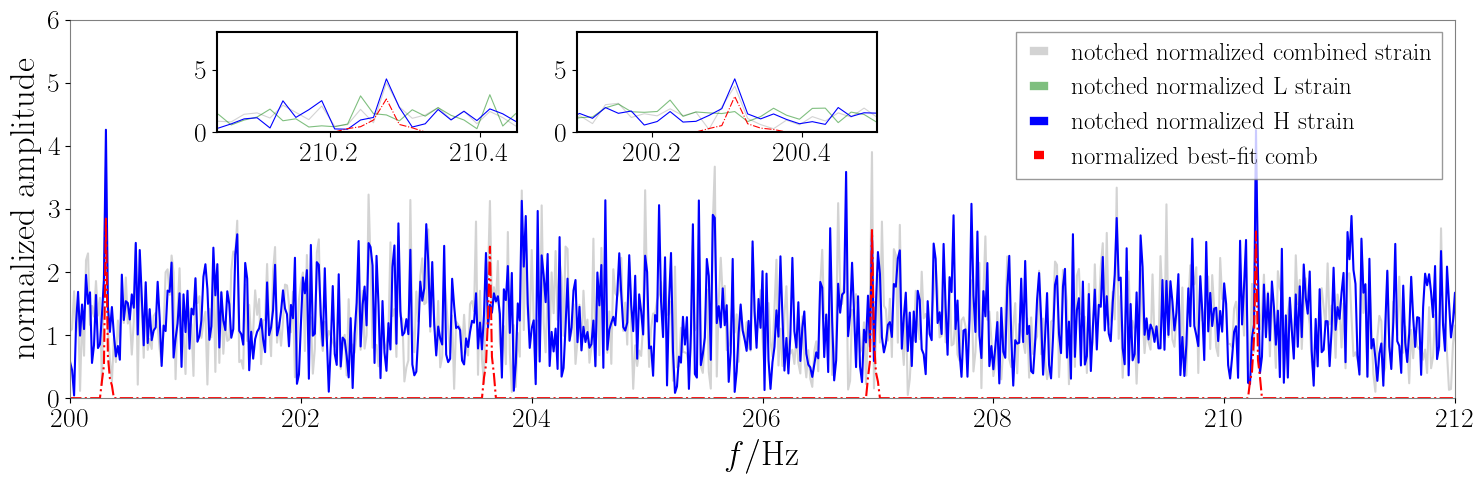

In [10]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(15, 5))

main_ax = plt.gca()

plt.plot(frequency, np.abs(strainfreN_g * np.sqrt(psd_strainLH_list * (4 * df))),
         label='notched normalized combined strain', color='lightgray')
plt.plot([], [], color='green', alpha=0.5, label='notched normalized L strain')
plt.plot(frequency, np.abs(strainHfre_normalized_abs),
         label='notched normalized H strain', color='b')
plt.plot(frequencye_g, np.abs(hi_g * np.sqrt((4 * df) / psd_strainH(frequencye_g) +
                                             res_amplitude_g**2 * (4 * df) / psd_strainL(frequencye_g))),
         label='normalized best-fit comb', color='r', linestyle='-.')
plt.grid(False)
plt.axis([fmin_g, fmax_g, 0, 8])
plt.xlim(200, 212)
plt.ylim(0,6)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.ylabel('normalized amplitude', fontsize=25)
plt.xlabel(r'$f/\mathrm{Hz}$', fontsize=25)

plt.legend(loc='upper right', fontsize=18)

for i, (xlim, pos) in enumerate([((210.05, 210.45), [0.15, 0.72, 0.2, 0.2]),
                                 ((200.1, 200.5), [0.39, 0.72, 0.2, 0.2])]):
    ax = plt.axes(pos)
    ax.plot(frequency, np.abs(strainfreN_g * np.sqrt(psd_strainLH_list * (4 * df))),
            color='lightgray', linewidth=0.8)
    ax.plot(frequency, np.abs(strainLfre_normalized_abs),
            color='green', linewidth=0.8, alpha=0.5)
    ax.plot(frequency, np.abs(strainHfre_normalized_abs),
            color='b', linewidth=0.8)
    ax.plot(frequencye_g, np.abs(hi_g * np.sqrt((4 * df) / psd_strainH(frequencye_g) +
               res_amplitude_g**2 * (4 * df) / psd_strainL(frequencye_g))),
            color='r', linestyle='-.', linewidth=0.8)

    ax.set_xlim(xlim)
    ax.set_ylim(0, 8)
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=20)

    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
# plt.rc('xtick', labelsize=25)
# plt.rc('ytick', labelsize=25)
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

plt.tight_layout()
plt.savefig('GW250114duration58oldHstrain.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Figure.12: Corner plot of Guassian noise

## Newlikelihood duration $\Delta f_{\mathrm{max}} = 400$ corner plot

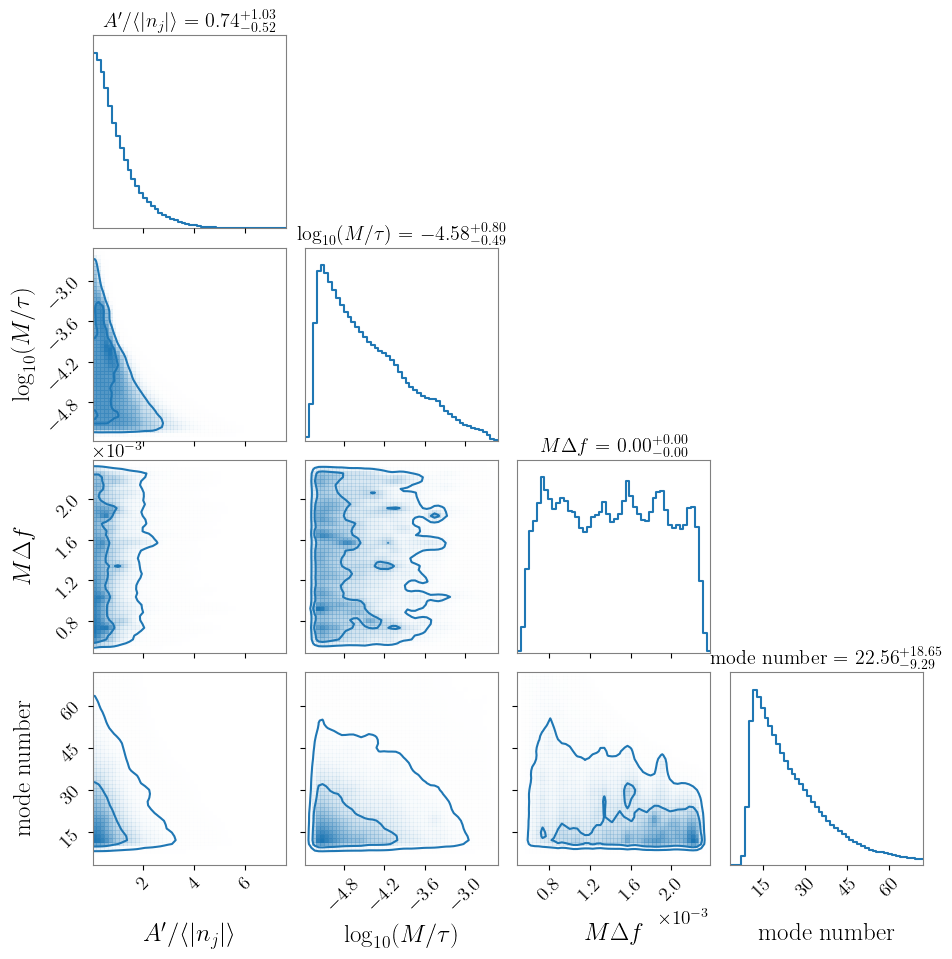

In [ ]:
import json
import corner
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False


# G = 6.67430e-11
# c = 299792458
# M_sun = 1.988409870698051e30
# M = 67.7
# factor = c**3 / G / M_sun / M
# the factor is used to convert natural unit to Hz
# In this case, we do not need to convert the unit, so factor=1
factor = 1

result_path = "GuassianN200newlikelihood.json"

try:
    with open(result_path, 'r') as f:
        result_data = json.load(f)
except FileNotFoundError:
    print("Warning: File not found, generating mock data for demonstration.")
    np.random.seed(42)
    n = 5000
    posterior_data = {
        'amplitude': np.random.lognormal(mean=np.log(1e-22), sigma=0.8, size=n),
        'width': np.random.lognormal(mean=np.log(10), sigma=0.3, size=n),
        'spacing': np.random.normal(loc=30, scale=5, size=n),
        'fmin': np.random.normal(loc=20, scale=2, size=n),
        'fmax': np.random.normal(loc=150, scale=10, size=n)
    }
    result_data = {'posterior': posterior_data}

if 'posterior' in result_data:
    posterior_data = result_data['posterior']
elif 'samples' in result_data:
    posterior_data = result_data['samples']
else:
    sample_keys = [k for k in result_data.keys() if isinstance(result_data[k], (list, dict))]
    posterior_data = result_data[sample_keys[0]]
posterior = pd.DataFrame(posterior_data)

noise_mean_linear = (3.28)
noise_mean_log = np.log10(noise_mean_linear)
A_min_linear = noise_mean_linear * 100
A_min_log = np.log10(A_min_linear)

amp_vals = posterior['amplitude'].values/A_min_linear
width_vals = posterior['width'].values*factor
spacing_vals = posterior['spacing'].values*factor
df_over_spacing = (posterior['fmax'].values - posterior['fmin'].values) / spacing_vals

def to_log10_safe(arr):
    arr = arr.copy()
    mask_pos = arr > 0
    if not np.all(mask_pos):
        min_pos = arr[mask_pos].min() if any(mask_pos) else 1e-30
        arr[~mask_pos] = min_pos
    return np.log10(arr)
amp_linear = amp_vals # change to linear scale
width_log = to_log10_safe(width_vals)

raw_data = np.stack([amp_linear, width_log, spacing_vals, df_over_spacing], axis=1)
clean_mask = np.all(np.isfinite(raw_data), axis=1)
final_data = raw_data[clean_mask]

def get_full_range(data_array, padding=0.05):

    d_min, d_max = np.min(data_array), np.max(data_array)
    span = d_max - d_min
    return [d_min - padding * span, d_max + padding * span]
plot_ranges = [
    get_full_range(final_data[:, 0]), # Amplitude (linear)
    get_full_range(final_data[:, 1]), # Width (log)
    get_full_range(final_data[:, 2]), # Spacing (linear)
    get_full_range(final_data[:, 3]) # (fmax-fmin)/spacing (linear)
]

amp_min = np.min(final_data[:, 0])
amp_max = np.max(final_data[:, 0])
plot_ranges[0][0] = amp_min
plot_ranges[0][1] = amp_max

mode_max = np.max(final_data[:, 3])
plot_ranges[3][1] = mode_max * 0.5

labels = [
    r"$A^\prime/\langle |n_j|\rangle$",
    r"$\log_{10}(M/\tau )$",
    r"$M\mathrm{\Delta} f$",
    # r"$(f_{\max}-f_{\min})/\mathrm{Spacing}$"
    'mode number'
]
kwargs = dict(
    labels=labels,
    range=plot_ranges,
    show_titles=True,
    title_fmt=".2f",
    title_quantiles=[0.16, 0.5, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    color='C0',
    bins=50,
    plot_datapoints=False,
    plot_contours=True,
    fill_contours=False,
    no_fill_contours=True,
    smooth=0.8,
    smooth1d=0.8,
    label_kwargs=dict(fontsize=18)
)
fig = corner.corner(final_data, **kwargs)
axes = np.array(fig.axes).reshape(4, 4)

ax_amp = axes[0, 0]
ymin, ymax = ax_amp.get_ylim()
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

for ax in fig.get_axes():
    ax.grid(False)
    ax.grid(False, which='both')
    ax.minorticks_off()
    ax.set_axisbelow(False)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.savefig("Guassian_N200_new_4parameters_corner.pdf", dpi=300, bbox_inches='tight')
plt.show()


##  Oldlikelihood duration $T\Delta f_{\mathrm{max}} = 400$ corner plot

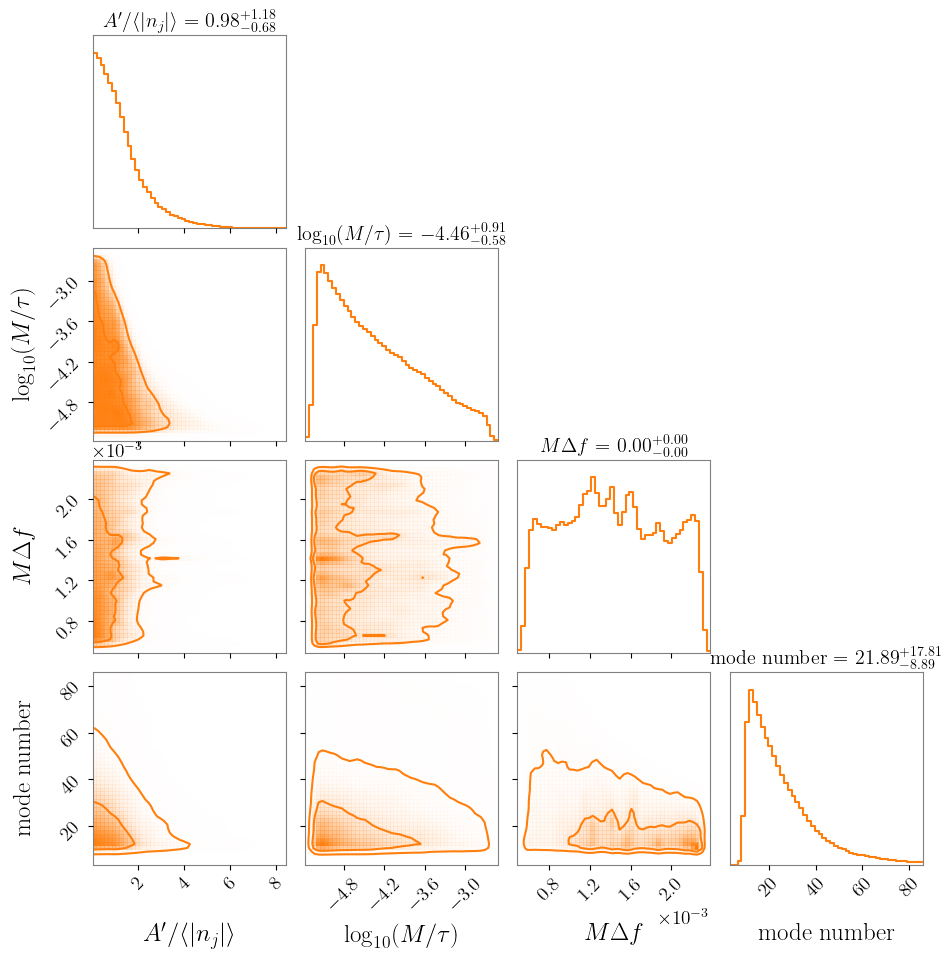

In [ ]:
import json
import corner
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# G = 6.67430e-11
# c = 299792458
# M_sun = 1.988409870698051e30
# M = 67.7
# factor = c**3 / G / M_sun / M
# the factor is used to convert natural unit to Hz
# In this case, we do not need to convert the unit, so factor=1
factor = 1

result_path = "GuassianN200oldlikelihood.json"

try:
    with open(result_path, 'r') as f:
        result_data = json.load(f)
except FileNotFoundError:
    print("Warning: File not found, generating mock data for demonstration.")
    np.random.seed(42)
    n = 5000
    posterior_data = {
        'amplitude': np.random.lognormal(mean=np.log(1e-22), sigma=0.8, size=n),
        'width': np.random.lognormal(mean=np.log(10), sigma=0.3, size=n),
        'spacing': np.random.normal(loc=30, scale=5, size=n),
        'fmin': np.random.normal(loc=20, scale=2, size=n),
        'fmax': np.random.normal(loc=150, scale=10, size=n)
    }
    result_data = {'posterior': posterior_data}

if 'posterior' in result_data:
    posterior_data = result_data['posterior']
elif 'samples' in result_data:
    posterior_data = result_data['samples']
else:
    sample_keys = [k for k in result_data.keys() if isinstance(result_data[k], (list, dict))]
    posterior_data = result_data[sample_keys[0]]
posterior = pd.DataFrame(posterior_data)

noise_mean_linear = (3.28)
noise_mean_log = np.log10(noise_mean_linear)
A_min_linear = noise_mean_linear * 100
A_min_log = np.log10(A_min_linear)

amp_vals = posterior['amplitude'].values/A_min_linear
width_vals = posterior['width'].values*factor
spacing_vals = posterior['spacing'].values*factor
df_over_spacing = (posterior['fmax'].values - posterior['fmin'].values) / spacing_vals

def to_log10_safe(arr):
    arr = arr.copy()
    mask_pos = arr > 0
    if not np.all(mask_pos):
        min_pos = arr[mask_pos].min() if any(mask_pos) else 1e-30
        arr[~mask_pos] = min_pos
    return np.log10(arr)
amp_linear = amp_vals
width_log = to_log10_safe(width_vals)

raw_data = np.stack([amp_linear, width_log, spacing_vals, df_over_spacing], axis=1)
clean_mask = np.all(np.isfinite(raw_data), axis=1)
final_data = raw_data[clean_mask]

def get_full_range(data_array, padding=0.05):

    d_min, d_max = np.min(data_array), np.max(data_array)
    span = d_max - d_min
    return [d_min - padding * span, d_max + padding * span]
plot_ranges = [
    get_full_range(final_data[:, 0]), # Amplitude (linear)
    get_full_range(final_data[:, 1]), # Width (log)
    get_full_range(final_data[:, 2]), # Spacing (linear)
    get_full_range(final_data[:, 3]) # (fmax-fmin)/spacing (linear)
]

amp_min = np.min(final_data[:, 0])
amp_max = np.max(final_data[:, 0])
plot_ranges[0][0] = amp_min
plot_ranges[0][1] = amp_max

mode_max = np.max(final_data[:, 3])
plot_ranges[3][1] = mode_max * 0.6

labels = [
    r"$A^\prime/\langle |n_j|\rangle$",
    r"$\log_{10}(M/\tau)$",
    r"$M\Delta f$",
    # r"$(f_{\max}-f_{\min})/\mathrm{Spacing}$"
    'mode number'
]
kwargs = dict(
    labels=labels,
    range=plot_ranges,
    show_titles=True,
    title_fmt=".2f",
    title_quantiles=[0.16, 0.5, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    color='C1',
    bins=50,
    plot_datapoints=False,
    plot_contours=True,
    fill_contours=False,
    no_fill_contours=True,
    smooth=0.8,
    smooth1d=0.8,
    label_kwargs=dict(fontsize=18)
)
fig = corner.corner(final_data, **kwargs)
axes = np.array(fig.axes).reshape(4, 4)

ax_amp = axes[0, 0]
ymin, ymax = ax_amp.get_ylim()
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.subplots_adjust(wspace=0.1, hspace=0.1)

for ax in fig.get_axes():
    ax.grid(False)
    ax.grid(False, which='both')
    ax.minorticks_off()
    ax.set_axisbelow(False)

plt.savefig("Guassian_N200_old_4parameters_corner.pdf", dpi=300, bbox_inches='tight')
plt.show()
